In [748]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../code/')
from utilsFuncs import *
from ldaSingleCell import VariationalLDA
from scipy import spatial
from scipy.stats import binom
from statsmodels.stats.multitest import multipletests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
metaData = pd.read_csv("/data/Alex/PIC_seq_data/GSE135382_metadata2.txt",sep="\t")

In [3]:
metaData.head()

,well,amplifaction_batch,sequencing_batch,tissue,sorting_scheme,treatment,timepoint,replicate,well_coordinates,Pool_barcode,Cell_barcode,Number_of_cells
0,WMC1016609,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,A1,GATGCTCA,CTATTCG,1
1,WMC1016610,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,C1,GATGCTCA,ACTCAGG,1
2,WMC1016611,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,E1,GATGCTCA,ACACGTG,1
3,WMC1016612,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,G1,GATGCTCA,TCTTCGA,1
4,WMC1016613,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,I1,GATGCTCA,AGCACTG,1


In [4]:
metaData[metaData['treatment']=="Co-culture"]

,well,amplifaction_batch,sequencing_batch,tissue,sorting_scheme,treatment,timepoint,replicate,well_coordinates,Pool_barcode,Cell_barcode,Number_of_cells
0,WMC1016609,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,A1,GATGCTCA,CTATTCG,1
1,WMC1016610,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,C1,GATGCTCA,ACTCAGG,1
2,WMC1016611,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,E1,GATGCTCA,ACACGTG,1
3,WMC1016612,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,G1,GATGCTCA,TCTTCGA,1
4,WMC1016613,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,I1,GATGCTCA,AGCACTG,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16507,WMC1088796,AB6219,SB309,in vitro,TCRb+,Co-culture,48h,1,H24,GACCTCGA,GGACATT,1
16508,WMC1088797,AB6219,SB309,in vitro,TCRb+,Co-culture,48h,1,J24,GACCTCGA,ATTCAGC,1
16509,WMC1088798,AB6219,SB309,in vitro,TCRb+,Co-culture,48h,1,L24,GACCTCGA,ATTCGCG,1
16510,WMC1088799,AB6219,SB309,in vitro,TCRb+,Co-culture,48h,1,N24,GACCTCGA,TGAAGCT,1


In [5]:
files_tcells = np.unique(metaData[(metaData['sorting_scheme']=='TCRb+')
                   & (metaData['treatment']=='Mono-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_tcells

array(['AB6039', 'AB6040', 'AB6199', 'AB6200', 'AB6211', 'AB6220',
       'AB6221'], dtype=object)

In [6]:
#creating a merged matrix of all DCs: 
files_dcs = np.unique(metaData[(metaData['sorting_scheme']=='CD11c+')
                   & (metaData['treatment']=='Mono-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_dcs

array(['AB6037', 'AB6038', 'AB6197', 'AB6198', 'AB6212', 'AB6213',
       'AB6222', 'AB6223'], dtype=object)

In [7]:
def concatData(fileIds):
    path  = "/data/Alex/PIC_seq_data/"
    files = []
    for a in fileIds: 
        filename = glob.glob(path+"*_" +a+ ".txt")
        files.append(filename[0])
    df_from_each_file = (pd.read_csv(f,sep='\t',index_col=0) for f in files)
    concatenated_df   = pd.concat(df_from_each_file, axis=1)
    return concatenated_df

In [8]:
dcs = concatData(files_dcs)

In [9]:
dcs.shape

(52634, 3072)

In [10]:
tcells = concatData(files_tcells)

In [11]:
tcells.shape

(52634, 2688)

In [12]:
all_mono = pd.concat([dcs,tcells],axis = 1)

In [13]:
all_mono.shape

(52634, 5760)

In [14]:
tcells = tcells.loc[all_mono[all_mono.astype(bool).sum(axis=1)>5].index]
dcs = dcs.loc[all_mono[all_mono.astype(bool).sum(axis=1)>5].index]

In [15]:
tcells.shape

(13662, 2688)

In [16]:
tcells_sample = tcells.T.sample(n=200, random_state=1)

In [17]:
dc_sample = dcs.T.sample(n=200, random_state=1)

In [18]:
all_samples = pd.concat([tcells_sample.T,dc_sample.T],axis = 1)
#saving output for reproducibility

In [19]:
all_samples.to_csv("/data/Alex/LDAfiles/syntheticDoublets.csv")

In [22]:
doublets_5050 = (tcells_sample.values+dc_sample.values)/2

In [23]:
doublets_6040 = 0.6*tcells_sample.values+0.4*dc_sample.values

In [24]:
doublets_7030 = 0.3*tcells_sample.values+0.7*dc_sample.values

In [25]:
up_regulate = ["Sell","Mif","Bcl2l1","Cd40","Myc","Ncl","Cst3","Ly6a","Ctla4","Ccl22", "Cd69","Dll4","Lgals1"]

In [82]:
len(up_regulate)

13

In [26]:
up_regulate_subset = ["Gbp4","Gbp7","Gzmb","Il2ra","Psma4"]

In [27]:
len(up_regulate)

13

In [28]:
singleCellLDA = VariationalLDA(K = 50,alpha = 1,eta=0.005,update_alpha=True)

In [29]:
singleCellLDA.load_data_sc(all_samples)

Edited


In [30]:
singleCellLDA.run_vb(n_its = 1000,initialise=True)

Initialising
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 78.76676567923168) (11.469999999999992 seconds, I think I'll finish in 191.16666666666652 minutes). Alpha: (1.9295167619563223,15.013300176435932)
Iteration 1 (change = 1.5964530692206031) (10.110000000000014 seconds, I think I'll finish in 168.33150000000023 minutes). Alpha: (2.448656317874599,22.71952050490971)
Iteration 2 (change = 1.5939875539395365) (10.319999999999993 seconds, I think I'll finish in 171.6559999999999 minutes). Alpha: (2.739546129913376,26.810927819898637)
Iteration 3 (change = 1.5703884178452494) (10.400000000000006 seconds, I think I'll finish in 172.81333333333345 minutes). Alpha: (2.878478996114483,28.729294495869812)
Iteration 4 (change = 1.5692902825383104) (10.08999999999999 seconds, I think I'll finish in 167.4939999999998 minutes). Alpha: (2.906753521351055,29.205822597654265)
Iteration 5 (change = 1.6027570369768216) (10.150000000000006 seconds, I think I'll finish in 168.3208333333334 minutes). Alpha: (2.8561201917767858,28.7146242

Iteration 49 (change = 1.2963507204911966) (9.740000000000009 seconds, I think I'll finish in 154.37900000000016 minutes). Alpha: (0.01804414891620054,1.0963487897131101)
Iteration 50 (change = 1.2306990785503102) (9.759999999999991 seconds, I think I'll finish in 154.5333333333332 minutes). Alpha: (0.017278248079153343,1.0601110466544943)
Iteration 51 (change = 1.1708188046326184) (10.019999999999982 seconds, I think I'll finish in 158.48299999999972 minutes). Alpha: (0.016584423723855442,1.026745264811305)
Iteration 52 (change = 1.1170405326279444) (9.910000000000082 seconds, I think I'll finish in 156.57800000000128 minutes). Alpha: (0.01595220710725658,0.996000171229961)
Iteration 53 (change = 1.0692402180590652) (9.759999999999991 seconds, I think I'll finish in 154.0453333333332 minutes). Alpha: (0.015360074893130854,0.9674902134291532)
Iteration 54 (change = 1.0252165146397838) (9.669999999999959 seconds, I think I'll finish in 152.46366666666603 minutes). Alpha: (0.014799783969

Iteration 98 (change = 0.290277034709389) (9.659999999999854 seconds, I think I'll finish in 145.22199999999782 minutes). Alpha: (0.0046119851357150545,0.4500682144967455)
Iteration 99 (change = 0.284638256150176) (9.740000000000009 seconds, I think I'll finish in 146.2623333333335 minutes). Alpha: (0.0045308436383575445,0.4461124778675612)
Iteration 100 (change = 0.2805024308221712) (9.779999999999973 seconds, I think I'll finish in 146.69999999999956 minutes). Alpha: (0.004452856286867864,0.44230871233549496)
Iteration 101 (change = 0.2765854553233212) (9.730000000000018 seconds, I think I'll finish in 145.78783333333362 minutes). Alpha: (0.004377849700648924,0.4386274330760998)
Iteration 102 (change = 0.2745802624291279) (9.759999999999991 seconds, I think I'll finish in 146.07466666666653 minutes). Alpha: (0.004305653098608448,0.4351975221647041)
Iteration 103 (change = 0.2765828248393114) (9.650000000000091 seconds, I think I'll finish in 144.26750000000135 minutes). Alpha: (0.004

Iteration 146 (change = 0.08126970896119441) (9.660000000000082 seconds, I think I'll finish in 137.49400000000117 minutes). Alpha: (0.00247329868602873,0.36045518023841133)
Iteration 147 (change = 0.08026710244513893) (9.710000000000036 seconds, I think I'll finish in 138.04383333333382 minutes). Alpha: (0.0024511550654239458,0.35952478498126544)
Iteration 148 (change = 0.07997738621423518) (9.730000000000018 seconds, I think I'll finish in 138.16600000000025 minutes). Alpha: (0.0024295202878280753,0.3585782775355033)
Iteration 149 (change = 0.08058505469656808) (9.769999999999982 seconds, I think I'll finish in 138.57116666666641 minutes). Alpha: (0.002408380346301596,0.3576977634013319)
Iteration 150 (change = 0.0823556532236021) (9.589999999999918 seconds, I think I'll finish in 135.85833333333218 minutes). Alpha: (0.002387721224782454,0.35687327886415127)
Iteration 151 (change = 0.08521133209667264) (9.789999999999964 seconds, I think I'll finish in 138.5284999999995 minutes). Alp

Iteration 194 (change = 0.05651947986549462) (9.710000000000036 seconds, I think I'll finish in 130.43766666666716 minutes). Alpha: (0.0017941127081927126,0.3323609379606926)
Iteration 195 (change = 0.054688543027116794) (9.61999999999989 seconds, I think I'll finish in 129.06833333333188 minutes). Alpha: (0.0017853535047448782,0.3318632276007149)
Iteration 196 (change = 0.05306780668884189) (9.650000000000091 seconds, I think I'll finish in 129.31000000000122 minutes). Alpha: (0.0017767307470229641,0.33135658121351286)
Iteration 197 (change = 0.0518016565498506) (9.659999999999854 seconds, I think I'll finish in 129.28299999999805 minutes). Alpha: (0.0017682422645179667,0.3308759213559046)
Iteration 198 (change = 0.05105611803987575) (9.840000000000146 seconds, I think I'll finish in 131.52800000000195 minutes). Alpha: (0.0017598856813074203,0.3304131440975062)
Iteration 199 (change = 0.051062740493313045) (9.559999999999945 seconds, I think I'll finish in 127.62599999999927 minutes).

Iteration 241 (change = 0.027797395527423965) (9.639999999999873 seconds, I think I'll finish in 121.94599999999839 minutes). Alpha: (0.0014945381460543519,0.3162436517903391)
Iteration 242 (change = 0.027260851823301697) (9.690000000000055 seconds, I think I'll finish in 122.41700000000068 minutes). Alpha: (0.001490017372892853,0.3160239742975288)
Iteration 243 (change = 0.026819539658274674) (9.740000000000236 seconds, I think I'll finish in 122.88633333333631 minutes). Alpha: (0.0014855531819932136,0.31581129967108124)
Iteration 244 (change = 0.026404930825338412) (9.909999999999854 seconds, I think I'll finish in 124.86599999999817 minutes). Alpha: (0.0014811448770050634,0.31561115933211065)
Iteration 245 (change = 0.0259257478768591) (9.809999999999945 seconds, I think I'll finish in 123.44249999999933 minutes). Alpha: (0.00147679109666276,0.3153957263838786)
Iteration 246 (change = 0.02562614405419348) (9.7199999999998 seconds, I think I'll finish in 122.14799999999748 minutes). 

Iteration 288 (change = 0.02228928941715184) (9.7800000000002 seconds, I think I'll finish in 116.05600000000237 minutes). Alpha: (0.0012430348870685456,0.3082792640682896)
Iteration 289 (change = 0.021995011336936033) (9.980000000000018 seconds, I think I'll finish in 118.26300000000022 minutes). Alpha: (0.001238236170850626,0.3081434281981529)
Iteration 290 (change = 0.02168137578362657) (9.879999999999654 seconds, I think I'll finish in 116.91333333332925 minutes). Alpha: (0.0012334961648194436,0.30801313586255896)
Iteration 291 (change = 0.02128936443385029) (9.930000000000291 seconds, I think I'll finish in 117.33950000000344 minutes). Alpha: (0.0012288135799732854,0.3078688643657511)
Iteration 292 (change = 0.020791652936628185) (9.83999999999969 seconds, I think I'll finish in 116.11199999999636 minutes). Alpha: (0.001224186614551405,0.307679138462554)
Iteration 293 (change = 0.02022387315015024) (9.88000000000011 seconds, I think I'll finish in 116.41933333333462 minutes). Alph

Iteration 335 (change = 0.009757979969824743) (9.889999999999873 seconds, I think I'll finish in 109.61416666666524 minutes). Alpha: (0.001067465155713658,0.30211469760575826)
Iteration 336 (change = 0.009716311769055203) (10.019999999999982 seconds, I think I'll finish in 110.88799999999979 minutes). Alpha: (0.0010646032883359123,0.30197600603630737)
Iteration 337 (change = 0.009691543419760576) (9.940000000000055 seconds, I think I'll finish in 109.8370000000006 minutes). Alpha: (0.0010617694959886737,0.30183756391775535)
Iteration 338 (change = 0.00979713278243437) (9.730000000000018 seconds, I think I'll finish in 107.35433333333353 minutes). Alpha: (0.0010589635529107187,0.3017082993479891)
Iteration 339 (change = 0.009952727682333731) (10.0300000000002 seconds, I think I'll finish in 110.49716666666887 minutes). Alpha: (0.0010561851933432896,0.30158480602761556)
Iteration 340 (change = 0.010149885072782043) (9.879999999999654 seconds, I think I'll finish in 108.6799999999962 minu

Iteration 382 (change = 0.013399778666936264) (10.0 seconds, I think I'll finish in 103.0 minutes). Alpha: (0.0009585000941943005,0.2981738587708833)
Iteration 383 (change = 0.013611774544303115) (9.900000000000091 seconds, I think I'll finish in 101.80500000000093 minutes). Alpha: (0.0009566457167966235,0.29808371352344465)
Iteration 384 (change = 0.013862219530225381) (9.83999999999969 seconds, I think I'll finish in 101.02399999999683 minutes). Alpha: (0.0009548068124909611,0.2979928686032959)
Iteration 385 (change = 0.014146432049058766) (9.980000000000018 seconds, I think I'll finish in 102.2950000000002 minutes). Alpha: (0.0009529833360993412,0.29791384937448)
Iteration 386 (change = 0.014349187715720038) (9.840000000000146 seconds, I think I'll finish in 100.69600000000149 minutes). Alpha: (0.0009511751945639092,0.297842508626335)
Iteration 387 (change = 0.014381531527946419) (9.829999999999927 seconds, I think I'll finish in 100.4298333333326 minutes). Alpha: (0.000949382235102

Iteration 429 (change = 0.007875180954985158) (9.920000000000073 seconds, I think I'll finish in 94.40533333333403 minutes). Alpha: (0.0008857254715647149,0.29458403203352296)
Iteration 430 (change = 0.007890055592474672) (9.9399999999996 seconds, I think I'll finish in 94.4299999999962 minutes). Alpha: (0.0008844500846199189,0.2945556563422171)
Iteration 431 (change = 0.00793208585627389) (9.900000000000546 seconds, I think I'll finish in 93.88500000000518 minutes). Alpha: (0.0008831844342142327,0.2945283101937577)
Iteration 432 (change = 0.007993354089569055) (9.829999999999927 seconds, I think I'll finish in 93.05733333333265 minutes). Alpha: (0.0008819284253909892,0.2945013638485596)
Iteration 433 (change = 0.008057736453689549) (9.88000000000011 seconds, I think I'll finish in 93.36600000000104 minutes). Alpha: (0.0008806819477550364,0.29447310416040245)
Iteration 434 (change = 0.008102705577397335) (9.929999999999382 seconds, I think I'll finish in 93.67299999999416 minutes). Alp

Iteration 476 (change = 0.0061404685993872166) (9.889999999999418 seconds, I think I'll finish in 86.37266666666159 minutes). Alpha: (0.000834820699735266,0.2928124990762264)
Iteration 477 (change = 0.006118238686260542) (9.8700000000008 seconds, I think I'll finish in 86.03350000000698 minutes). Alpha: (0.0008339102138125515,0.29276243829564214)
Iteration 478 (change = 0.006074190201144695) (9.899999999999636 seconds, I think I'll finish in 86.12999999999684 minutes). Alpha: (0.0008330056751238775,0.29270062116269635)
Iteration 479 (change = 0.006016698430852914) (9.88000000000011 seconds, I think I'll finish in 85.79133333333428 minutes). Alpha: (0.0008321069720868212,0.292631901131857)
Iteration 480 (change = 0.005964953771280061) (9.9399999999996 seconds, I think I'll finish in 86.1466666666632 minutes). Alpha: (0.0008312141279229348,0.29257140617902827)
Iteration 481 (change = 0.005964366999834157) (10.110000000000582 seconds, I think I'll finish in 87.45150000000504 minutes). Alp

Iteration 523 (change = 0.008213707301702622) (9.819999999999709 seconds, I think I'll finish in 78.06899999999769 minutes). Alpha: (0.0007979358683422143,0.29157515721018235)
Iteration 524 (change = 0.007949659557487521) (9.900000000000546 seconds, I think I'll finish in 78.54000000000433 minutes). Alpha: (0.0007972684682101699,0.2915728319296044)
Iteration 525 (change = 0.007796449602272328) (9.840000000000146 seconds, I think I'll finish in 77.90000000000116 minutes). Alpha: (0.0007966054129331187,0.29156830997640615)
Iteration 526 (change = 0.00768510085924359) (9.909999999999854 seconds, I think I'll finish in 78.28899999999885 minutes). Alpha: (0.0007959466679218984,0.2915637034351896)
Iteration 527 (change = 0.007613076292128502) (9.889999999999418 seconds, I think I'll finish in 77.96616666666208 minutes). Alpha: (0.0007952921976984192,0.29155889895748516)
Iteration 528 (change = 0.007566866077231097) (9.920000000000073 seconds, I think I'll finish in 78.0373333333339 minutes).

Iteration 570 (change = 0.007698740208875073) (9.779999999999745 seconds, I think I'll finish in 70.08999999999817 minutes). Alpha: (0.000770614810491592,0.2904331992715304)
Iteration 571 (change = 0.00774583497640198) (9.820000000000618 seconds, I think I'll finish in 70.21300000000443 minutes). Alpha: (0.0007701131219777142,0.2904260755987093)
Iteration 572 (change = 0.007791319641544376) (9.86999999999989 seconds, I think I'll finish in 70.40599999999922 minutes). Alpha: (0.0007696144889341119,0.29041888513712194)
Iteration 573 (change = 0.007822559000881996) (9.859999999999673 seconds, I think I'll finish in 70.170333333331 minutes). Alpha: (0.0007691188729995013,0.29040966416806363)
Iteration 574 (change = 0.007799725883419385) (9.850000000000364 seconds, I think I'll finish in 69.93500000000259 minutes). Alpha: (0.0007686261346806574,0.29038514895668543)
Iteration 575 (change = 0.007808706230307322) (9.840000000000146 seconds, I think I'll finish in 69.70000000000103 minutes). Al

Iteration 617 (change = 0.008815664682908089) (9.88000000000011 seconds, I think I'll finish in 63.06733333333403 minutes). Alpha: (0.0007498622525880728,0.28927170039915456)
Iteration 618 (change = 0.008787638029717397) (10.029999999999745 seconds, I think I'll finish in 63.85766666666505 minutes). Alpha: (0.000749477479291332,0.28926141341247535)
Iteration 619 (change = 0.008811490803335006) (9.970000000000255 seconds, I think I'll finish in 63.30950000000162 minutes). Alpha: (0.0007490949069058222,0.28925229980243894)
Iteration 620 (change = 0.008869281818835421) (10.079999999999927 seconds, I think I'll finish in 63.83999999999954 minutes). Alpha: (0.0007487145246736053,0.2892438289983775)
Iteration 621 (change = 0.008931378305757468) (10.090000000000146 seconds, I think I'll finish in 63.73516666666759 minutes). Alpha: (0.0007483363072532136,0.2892339881795173)
Iteration 622 (change = 0.008979578535762424) (10.159999999999854 seconds, I think I'll finish in 64.00799999999909 minut

Iteration 664 (change = 0.034708874489509524) (10.210000000000036 seconds, I think I'll finish in 57.1760000000002 minutes). Alpha: (0.0007339240514450872,0.2887818927647267)
Iteration 665 (change = 0.033750610218701446) (10.139999999999418 seconds, I think I'll finish in 56.61499999999675 minutes). Alpha: (0.0007336272585866062,0.28877460078283357)
Iteration 666 (change = 0.03275858402645373) (10.180000000000291 seconds, I think I'll finish in 56.66866666666829 minutes). Alpha: (0.0007333320381170902,0.28876577535794906)
Iteration 667 (change = 0.03143462447990435) (10.199999999999818 seconds, I think I'll finish in 56.60999999999899 minutes). Alpha: (0.000733038277120301,0.28874229673849094)
Iteration 668 (change = 0.029894903519332064) (10.180000000000291 seconds, I think I'll finish in 56.329333333334944 minutes). Alpha: (0.0007327460054090447,0.2887239849417069)
Iteration 669 (change = 0.028394897130696553) (10.100000000000364 seconds, I think I'll finish in 55.71833333333534 minu

Iteration 711 (change = 0.00885145286874925) (10.220000000000255 seconds, I think I'll finish in 49.22633333333456 minutes). Alpha: (0.0007215021223566241,0.28822581368487055)
Iteration 712 (change = 0.008806575943226208) (10.210000000000036 seconds, I think I'll finish in 49.00800000000017 minutes). Alpha: (0.0007212686378631113,0.2882126831169479)
Iteration 713 (change = 0.008760487676911994) (10.1200000000008 seconds, I think I'll finish in 48.407333333337164 minutes). Alpha: (0.0007210363172815534,0.28820160330603073)
Iteration 714 (change = 0.008712649661708495) (10.269999999999527 seconds, I think I'll finish in 48.95366666666441 minutes). Alpha: (0.0007208051644176212,0.28819211273792367)
Iteration 715 (change = 0.008662629729012829) (10.199999999999818 seconds, I think I'll finish in 48.449999999999136 minutes). Alpha: (0.0007205751803162764,0.2881837990533331)
Iteration 716 (change = 0.008609578800765056) (10.0 seconds, I think I'll finish in 47.333333333333336 minutes). Alpha

Iteration 758 (change = 0.007111604117701669) (10.100000000000364 seconds, I think I'll finish in 40.736666666668135 minutes). Alpha: (0.0007116316703572957,0.2874063517724553)
Iteration 759 (change = 0.007117020091831675) (10.170000000000073 seconds, I think I'll finish in 40.84950000000029 minutes). Alpha: (0.0007114449104468198,0.2874056277329679)
Iteration 760 (change = 0.007123911381174562) (10.279999999999745 seconds, I think I'll finish in 41.11999999999898 minutes). Alpha: (0.0007112591298064947,0.28740505507679165)
Iteration 761 (change = 0.00713205711052818) (10.170000000000073 seconds, I think I'll finish in 40.51050000000029 minutes). Alpha: (0.000711074324025407,0.2874046028606635)
Iteration 762 (change = 0.0071413078158110346) (10.329999999999927 seconds, I think I'll finish in 40.97566666666638 minutes). Alpha: (0.0007108904885536516,0.28740424469688486)
Iteration 763 (change = 0.007151795182426902) (10.390000000000327 seconds, I think I'll finish in 41.040500000001295 m

Iteration 805 (change = 0.00810718956693165) (10.210000000000036 seconds, I think I'll finish in 33.18250000000012 minutes). Alpha: (0.0007038074975825528,0.28691280592548085)
Iteration 806 (change = 0.008154061860822756) (10.319999999999709 seconds, I think I'll finish in 33.36799999999906 minutes). Alpha: (0.0007036586979307585,0.28689201106594114)
Iteration 807 (change = 0.008207308423868305) (10.360000000000582 seconds, I think I'll finish in 33.32466666666854 minutes). Alpha: (0.0007035105694785238,0.28687357750807185)
Iteration 808 (change = 0.008257759538975085) (10.4399999999996 seconds, I think I'll finish in 33.40799999999872 minutes). Alpha: (0.0007033631203474424,0.2868569202698955)
Iteration 809 (change = 0.008254089228031482) (10.280000000000655 seconds, I think I'll finish in 32.72466666666875 minutes). Alpha: (0.0007032163453097204,0.2868399847388583)
Iteration 810 (change = 0.008178761970279468) (10.289999999999964 seconds, I think I'll finish in 32.58499999999989 minu

Iteration 852 (change = 0.00739348588015768) (10.19000000000051 seconds, I think I'll finish in 25.13533333333459 minutes). Alpha: (0.0006806864591390685,0.28574338789814274)
Iteration 853 (change = 0.007433503476853432) (10.069999999999709 seconds, I think I'll finish in 24.671499999999288 minutes). Alpha: (0.0006789486078955138,0.28571157823365956)
Iteration 854 (change = 0.007491791034701661) (10.069999999999709 seconds, I think I'll finish in 24.503666666665957 minutes). Alpha: (0.000677223743050744,0.2856797792809074)
Iteration 855 (change = 0.00749612609397846) (10.239999999999782 seconds, I think I'll finish in 24.74666666666614 minutes). Alpha: (0.0006755117130886493,0.28564607607769305)
Iteration 856 (change = 0.007338214381456053) (10.180000000000291 seconds, I think I'll finish in 24.4320000000007 minutes). Alpha: (0.0006738123399190223,0.28560569188399654)
Iteration 857 (change = 0.00726377344843987) (10.139999999999418 seconds, I think I'll finish in 24.166999999998612 min

Iteration 899 (change = 0.0056526869586629395) (10.159999999999854 seconds, I think I'll finish in 17.102666666666423 minutes). Alpha: (0.0006110192808371064,0.2833630346312885)
Iteration 900 (change = 0.005575851007138489) (10.090000000000146 seconds, I think I'll finish in 16.816666666666908 minutes). Alpha: (0.0006097652582956947,0.28326129919616266)
Iteration 901 (change = 0.005513273661752116) (10.110000000000582 seconds, I think I'll finish in 16.68150000000096 minutes). Alpha: (0.0006085191786763859,0.2831664915444531)
Iteration 902 (change = 0.005445324465396505) (10.020000000000437 seconds, I think I'll finish in 16.366000000000714 minutes). Alpha: (0.0006072809033589553,0.28306492514475357)
Iteration 903 (change = 0.005395523068375555) (10.159999999999854 seconds, I think I'll finish in 16.425333333333096 minutes). Alpha: (0.0006060503855090233,0.28297380099016717)
Iteration 904 (change = 0.005351289344869436) (10.069999999999709 seconds, I think I'll finish in 16.11199999999

Iteration 946 (change = 0.0037698800829553463) (9.8799999999992 seconds, I think I'll finish in 8.89199999999928 minutes). Alpha: (0.0005596944025255851,0.28132472668412933)
Iteration 947 (change = 0.0037955680739612655) (10.020000000000437 seconds, I think I'll finish in 8.851000000000386 minutes). Alpha: (0.000558752342832906,0.2813102666055629)
Iteration 948 (change = 0.0038281023401981417) (10.05999999999949 seconds, I think I'll finish in 8.718666666666225 minutes). Alpha: (0.0005578157522928844,0.28129622212913025)
Iteration 949 (change = 0.0038688347445952637) (10.139999999999418 seconds, I think I'll finish in 8.618999999999506 minutes). Alpha: (0.0005568845875704982,0.28128255913069095)
Iteration 950 (change = 0.003919056963518256) (10.070000000001528 seconds, I think I'll finish in 8.39166666666794 minutes). Alpha: (0.0005559588056307313,0.2812692395030961)
Iteration 951 (change = 0.003981770560925886) (10.029999999998836 seconds, I think I'll finish in 8.191166666665715 minu

Iteration 993 (change = 0.0046884737796389145) (10.05999999999949 seconds, I think I'll finish in 1.1736666666666073 minutes). Alpha: (0.0005206768041977906,0.2806049454972241)
Iteration 994 (change = 0.004616462098598324) (10.030000000000655 seconds, I think I'll finish in 1.0030000000000654 minutes). Alpha: (0.0005199498327483839,0.2805695704525639)
Iteration 995 (change = 0.004568279524797391) (10.219999999999345 seconds, I think I'll finish in 0.8516666666666121 minutes). Alpha: (0.0005192266037750031,0.2805380397667599)
Iteration 996 (change = 0.004524721698582423) (9.880000000001019 seconds, I think I'll finish in 0.6586666666667346 minutes). Alpha: (0.0005185071025648132,0.28050967892090933)
Iteration 997 (change = 0.004484991873559506) (10.019999999998618 seconds, I think I'll finish in 0.5009999999999308 minutes). Alpha: (0.0005177913122013165,0.2804838533288392)
Iteration 998 (change = 0.004446809125569007) (10.010000000000218 seconds, I think I'll finish in 0.333666666666673

In [31]:
singleCellLDA.beta_matrix.shape

(50, 13662)

In [32]:
betas_learned = pd.DataFrame(singleCellLDA.beta_matrix)
topic_dict = betas_learned.to_dict(orient='index')

In [33]:
topicWordsOriginal = pd.DataFrame(singleCellLDA.beta_matrix,columns=all_samples.index)
documentTopicsOriginal = pd.DataFrame(singleCellLDA.get_expect_theta(),index=all_samples.T.index)

In [34]:
#generate synthetic
doubletsdf = pd.DataFrame(doublets_5050,columns=tcells.index)
doubletsChanged = doubletsdf.copy()
doubletsChanged[up_regulate]+=10

In [200]:
doubletsSubset = pd.DataFrame(doublets_5050,columns=tcells.index)

In [201]:
doubletsSubset.loc[0:20,up_regulate_subset]+=10

In [37]:
dbl6040 = pd.DataFrame(doublets_6040, columns=tcells.index)
dbl6040[up_regulate]+=10

dbl3070 = pd.DataFrame(doublets_7030, columns=tcells.index)
dbl3070[up_regulate]+=10

In [38]:
scLDAUp = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.005,update_alpha=True, fixed_topics=topic_dict)

Object created with 400 documents


In [39]:
scLDAUp.load_data_sc(doubletsChanged.T)

scLDAUp.run_vb(n_its=1000,initialise=True)

Edited
Initialising
Here
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 32.83623842304531) (10.739999999999782 seconds, I think I'll finish in 178.99999999999636 minutes). Alpha: (1.5558183038066018,20.309542842709703)
Iteration 1 (change = 14.0353785680955) (9.880000000001019 seconds, I think I'll finish in 164.50200000001695 minutes). Alpha: (1.160703811540817,24.50204631737502)
Iteration 2 (change = 12.715500129422155) (10.05999999999949 seconds, I think I'll finish in 167.33133333332486 minutes). Alpha: (0.8744847900159659,20.66103144161928)
Iteration 3 (change = 8.051984258577306) (10.139999999999418 seconds, I think I'll finish in 168.49299999999033 minutes). Alpha: (0.6872370333992076,15.651461851741061)
Iteration 4 (change = 4.188366153336525) (9.920000000000073 seconds, I think I'll finish in 164.67200000000122 minutes). Alpha: (0.5407168294103535,11.7160417646205)
Iteration 5 (change = 2.53298524852931) (10.040000000000873 seconds, I think I'll finish in 166.49666666668114 minutes). Alpha: (0.43595241063253043,9.062532184589

Iteration 49 (change = 0.1436822380202444) (9.889999999999418 seconds, I think I'll finish in 156.75649999999078 minutes). Alpha: (0.0054655179509611514,0.8031662297485344)
Iteration 50 (change = 0.1254044544843526) (9.670000000000073 seconds, I think I'll finish in 153.10833333333449 minutes). Alpha: (0.0053150884073951,0.8000855348907272)
Iteration 51 (change = 0.11074064570825229) (9.700000000000728 seconds, I think I'll finish in 153.42166666667816 minutes). Alpha: (0.005172552924838345,0.7972663318870867)
Iteration 52 (change = 0.09955173192365048) (9.69000000000051 seconds, I think I'll finish in 153.10200000000805 minutes). Alpha: (0.0050373194216008325,0.7946828984617827)
Iteration 53 (change = 0.09100301120719738) (9.549999999999272 seconds, I think I'll finish in 150.73083333332184 minutes). Alpha: (0.0049088521645614235,0.7923061884855152)
Iteration 54 (change = 0.08423224842541373) (9.700000000000728 seconds, I think I'll finish in 152.93666666667815 minutes). Alpha: (0.004

Iteration 97 (change = 0.0764999176209414) (9.880000000001019 seconds, I think I'll finish in 148.69400000001534 minutes). Alpha: (0.002298563552633704,0.744912200306368)
Iteration 98 (change = 0.08546113120844018) (9.889999999999418 seconds, I think I'll finish in 148.6796666666579 minutes). Alpha: (0.002270858086760768,0.7435959158962158)
Iteration 99 (change = 0.0977977217362732) (9.840000000000146 seconds, I think I'll finish in 147.7640000000022 minutes). Alpha: (0.0022437940362775664,0.7421443246174818)
Iteration 100 (change = 0.11526237108263569) (9.869999999998981 seconds, I think I'll finish in 148.04999999998472 minutes). Alpha: (0.002217346722878662,0.7404860716640408)
Iteration 101 (change = 0.14015517495266364) (9.920000000000073 seconds, I think I'll finish in 148.63466666666775 minutes). Alpha: (0.0021914918439241067,0.7385533476382576)
Iteration 102 (change = 0.17490608172770047) (9.950000000000728 seconds, I think I'll finish in 148.91833333334424 minutes). Alpha: (0.0

Iteration 145 (change = 0.12094739413794257) (10.0 seconds, I think I'll finish in 142.5 minutes). Alpha: (0.0014373095769159396,0.6681847095309351)
Iteration 146 (change = 0.11415227242653829) (9.700000000000728 seconds, I think I'll finish in 138.06333333334368 minutes). Alpha: (0.0014259527273424442,0.6694308365378976)
Iteration 147 (change = 0.10814411318445677) (9.859999999998763 seconds, I think I'll finish in 140.17633333331574 minutes). Alpha: (0.0014147696153410804,0.6707152062206122)
Iteration 148 (change = 0.09267978244095872) (10.159999999999854 seconds, I think I'll finish in 144.27199999999794 minutes). Alpha: (0.0014037561218875208,0.6720370016685331)
Iteration 149 (change = 0.07914931824403035) (9.960000000000946 seconds, I think I'll finish in 141.2660000000134 minutes). Alpha: (0.0013929082048851685,0.6733910619960227)
Iteration 150 (change = 0.07793321096860022) (9.920000000000073 seconds, I think I'll finish in 140.53333333333435 minutes). Alpha: (0.0013822218773567

Iteration 193 (change = 0.042627361674315495) (10.100000000000364 seconds, I think I'll finish in 135.8450000000049 minutes). Alpha: (0.00103204477574755,0.6537225454019063)
Iteration 194 (change = 0.0404363452375304) (9.850000000000364 seconds, I think I'll finish in 132.31833333333822 minutes). Alpha: (0.0010258799226689707,0.6540439210926882)
Iteration 195 (change = 0.03886474789029311) (9.859999999998763 seconds, I think I'll finish in 132.28833333331673 minutes). Alpha: (0.0010197867145458988,0.65439056530762)
Iteration 196 (change = 0.03777665968192292) (10.040000000000873 seconds, I think I'll finish in 134.5360000000117 minutes). Alpha: (0.0010137639782190377,0.6547638215819318)
Iteration 197 (change = 0.03702141920475643) (10.039999999999054 seconds, I think I'll finish in 134.368666666654 minutes). Alpha: (0.0010078105454403522,0.6551583327007389)
Iteration 198 (change = 0.036514130300547225) (9.920000000000073 seconds, I think I'll finish in 132.59733333333432 minutes). Alph

Iteration 240 (change = 0.0638552027540789) (10.069999999999709 seconds, I think I'll finish in 127.55333333332965 minutes). Alpha: (0.0008028615907330488,0.6428866266824232)
Iteration 241 (change = 0.07942603670730833) (10.149999999999636 seconds, I think I'll finish in 128.3974999999954 minutes). Alpha: (0.0007989757048569823,0.6418625274065928)
Iteration 242 (change = 0.1043282661801185) (10.1200000000008 seconds, I think I'll finish in 127.84933333334344 minutes). Alpha: (0.0007951216974966474,0.6405241737489868)
Iteration 243 (change = 0.14624898708108333) (10.170000000000073 seconds, I think I'll finish in 128.3115000000009 minutes). Alpha: (0.0007912979428837899,0.6385731457099011)
Iteration 244 (change = 0.22058415877645698) (10.029999999998836 seconds, I think I'll finish in 126.37799999998533 minutes). Alpha: (0.0007875020643285512,0.6355810503487413)
Iteration 245 (change = 0.34879730531105524) (10.090000000000146 seconds, I think I'll finish in 126.96583333333517 minutes). 

Iteration 288 (change = 0.01760187448264725) (9.8799999999992 seconds, I think I'll finish in 117.24266666665717 minutes). Alpha: (0.0006478255300306098,0.6050754419037292)
Iteration 289 (change = 0.014065711823710107) (10.130000000001019 seconds, I think I'll finish in 120.04050000001207 minutes). Alpha: (0.0006452138915078968,0.6051374404345276)
Iteration 290 (change = 0.011678506141971036) (10.010000000000218 seconds, I think I'll finish in 118.45166666666925 minutes). Alpha: (0.0006426229846588327,0.6051976689598751)
Iteration 291 (change = 0.009894419463573188) (10.170000000000073 seconds, I think I'll finish in 120.17550000000087 minutes). Alpha: (0.0006400525495150304,0.6052459561206821)
Iteration 292 (change = 0.008468777527006411) (10.069999999999709 seconds, I think I'll finish in 118.82599999999657 minutes). Alpha: (0.0006375023115274538,0.6052698015516422)
Iteration 293 (change = 0.007800624642290064) (10.119999999998981 seconds, I think I'll finish in 119.24733333332134 mi

Iteration 335 (change = 0.005203494758117152) (10.029999999998836 seconds, I think I'll finish in 111.16583333332044 minutes). Alpha: (0.000544134046764434,0.6088054892978687)
Iteration 336 (change = 0.005161556405874976) (9.989999999999782 seconds, I think I'll finish in 110.55599999999758 minutes). Alpha: (0.0005422849429644048,0.608887312666151)
Iteration 337 (change = 0.005119202480096046) (10.130000000001019 seconds, I think I'll finish in 111.93650000001125 minutes). Alpha: (0.0005404482905623806,0.6089685287123183)
Iteration 338 (change = 0.005076550239543309) (10.029999999998836 seconds, I think I'll finish in 110.66433333332049 minutes). Alpha: (0.0005386239651078922,0.6090491355738306)
Iteration 339 (change = 0.005033550399118915) (10.079999999999927 seconds, I think I'll finish in 111.04799999999919 minutes). Alpha: (0.0005368118437832241,0.6091291326499194)
Iteration 340 (change = 0.004990124248161555) (10.200000000000728 seconds, I think I'll finish in 112.200000000008 min

Iteration 382 (change = 0.003053489916880573) (9.909999999999854 seconds, I think I'll finish in 102.0729999999985 minutes). Alpha: (0.0004689238093612959,0.6121253267229438)
Iteration 383 (change = 0.0030163992662537234) (9.920000000000073 seconds, I think I'll finish in 102.01066666666742 minutes). Alpha: (0.00046754783597953913,0.6121900707661047)
Iteration 384 (change = 0.0029799349011275333) (9.989999999999782 seconds, I think I'll finish in 102.56399999999776 minutes). Alpha: (0.00046617987765692955,0.6122549099020851)
Iteration 385 (change = 0.002944119444747065) (9.859999999998763 seconds, I think I'll finish in 101.06499999998732 minutes). Alpha: (0.0004648198646871416,0.6123198693514538)
Iteration 386 (change = 0.0029090045893089673) (9.970000000001164 seconds, I think I'll finish in 102.02633333334525 minutes). Alpha: (0.0004634677281583464,0.6123849746471474)
Iteration 387 (change = 0.002874633673390404) (9.930000000000291 seconds, I think I'll finish in 101.45150000000298 

Iteration 429 (change = 0.0022005455483766) (9.8799999999992 seconds, I think I'll finish in 94.02466666665904 minutes). Alpha: (0.00041191313361535855,0.6157436100191669)
Iteration 430 (change = 0.0022213835595206594) (9.930000000000291 seconds, I think I'll finish in 94.33500000000276 minutes). Alpha: (0.00041084962365813747,0.6158461630833)
Iteration 431 (change = 0.002243184140146069) (9.950000000000728 seconds, I think I'll finish in 94.35916666667357 minutes). Alpha: (0.0004097915556329441,0.6159504382171296)
Iteration 432 (change = 0.0022659779157979108) (9.899999999999636 seconds, I think I'll finish in 93.71999999999656 minutes). Alpha: (0.00040873888736512356,0.6160564833268061)
Iteration 433 (change = 0.002289763857936281) (9.8799999999992 seconds, I think I'll finish in 93.36599999999244 minutes). Alpha: (0.0004076915770930221,0.6161643470267039)
Iteration 434 (change = 0.002314558641570104) (9.960000000000946 seconds, I think I'll finish in 93.95600000000893 minutes). Alph

Iteration 476 (change = 0.004721806055627056) (10.0 seconds, I think I'll finish in 87.33333333333333 minutes). Alpha: (0.00036719224327416575,0.6232964074682382)
Iteration 477 (change = 0.004831601381749478) (9.860000000000582 seconds, I think I'll finish in 85.9463333333384 minutes). Alpha: (0.0003663446284687924,0.6235371769658689)
Iteration 478 (change = 0.004945738788381691) (9.909999999999854 seconds, I think I'll finish in 86.21699999999873 minutes). Alpha: (0.000365500830079378,0.623781695238058)
Iteration 479 (change = 0.0050643522996087565) (9.899999999999636 seconds, I think I'll finish in 85.96499999999683 minutes). Alpha: (0.00036466081915687557,0.6240298967366568)
Iteration 480 (change = 0.005187740998506959) (10.1200000000008 seconds, I think I'll finish in 87.7066666666736 minutes). Alpha: (0.00036382456685109276,0.6242816963530475)
Iteration 481 (change = 0.005316282942643122) (9.819999999999709 seconds, I think I'll finish in 84.94299999999748 minutes). Alpha: (0.0003

Iteration 524 (change = 0.11276465912999678) (10.109999999998763 seconds, I think I'll finish in 80.20599999999018 minutes). Alpha: (0.0003301732588354127,0.5803185598079341)
Iteration 525 (change = 0.08774116161931333) (10.030000000000655 seconds, I think I'll finish in 79.40416666667186 minutes). Alpha: (0.00032945917415688536,0.5792947645164997)
Iteration 526 (change = 0.07890333963363907) (9.829999999999927 seconds, I think I'll finish in 77.65699999999943 minutes). Alpha: (0.0003287478018921234,0.5784583292775037)
Iteration 527 (change = 0.07390575203757947) (10.069999999999709 seconds, I think I'll finish in 79.38516666666438 minutes). Alpha: (0.00032803918889614175,0.5777688734761902)
Iteration 528 (change = 0.06308702175373523) (9.890000000001237 seconds, I think I'll finish in 77.80133333334307 minutes). Alpha: (0.0003273333608851519,0.5771754414986994)
Iteration 529 (change = 0.04860682343968334) (9.799999999999272 seconds, I think I'll finish in 76.9299999999943 minutes). Al

Iteration 571 (change = 0.000606477855982869) (9.859999999998763 seconds, I think I'll finish in 70.49899999999116 minutes). Alpha: (0.0002995303911543826,0.5696736049650115)
Iteration 572 (change = 0.000594720134138196) (9.950000000000728 seconds, I think I'll finish in 70.97666666667186 minutes). Alpha: (0.0002989389924620081,0.5696202435393484)
Iteration 573 (change = 0.0005834112489274885) (9.979999999999563 seconds, I think I'll finish in 71.02433333333023 minutes). Alpha: (0.0002983499025623208,0.5695686888377178)
Iteration 574 (change = 0.0005725464888336198) (9.860000000000582 seconds, I think I'll finish in 70.00600000000414 minutes). Alpha: (0.00029776310856817657,0.569518854052257)
Iteration 575 (change = 0.0005620935643760504) (9.8700000000008 seconds, I think I'll finish in 69.91250000000566 minutes). Alpha: (0.00029717859766091413,0.5694706577376095)
Iteration 576 (change = 0.000552023173401842) (9.80999999999949 seconds, I think I'll finish in 69.3239999999964 minutes). 

Iteration 618 (change = 0.00032534172684352253) (9.920000000000073 seconds, I think I'll finish in 63.157333333333796 minutes). Alpha: (0.0002740345522170549,0.5682834393978551)
Iteration 619 (change = 0.0003224009579179383) (9.960000000000946 seconds, I think I'll finish in 63.246000000006006 minutes). Alpha: (0.00027353892675457665,0.5682674548028085)
Iteration 620 (change = 0.0003195125528995299) (9.969999999999345 seconds, I think I'll finish in 63.14333333332919 minutes). Alpha: (0.0002730450836873303,0.5682517613059351)
Iteration 621 (change = 0.0003166794637117232) (9.989999999999782 seconds, I think I'll finish in 63.10349999999862 minutes). Alpha: (0.0002725530135161407,0.5682363496554371)
Iteration 622 (change = 0.0003139025987605494) (9.94000000000051 seconds, I think I'll finish in 62.62200000000321 minutes). Alpha: (0.00027206270680646687,0.5682212109310338)
Iteration 623 (change = 0.0003111845323233752) (9.909999999999854 seconds, I think I'll finish in 62.26783333333242 

Iteration 665 (change = 0.0002336586384299582) (9.920000000001892 seconds, I think I'll finish in 55.38666666667723 minutes). Alpha: (0.00025252372971977034,0.5677393710886321)
Iteration 666 (change = 0.0002322203543891957) (9.899999999997817 seconds, I think I'll finish in 55.10999999998785 minutes). Alpha: (0.00025210257605273495,0.5677306423729239)
Iteration 667 (change = 0.0002307927901200273) (9.880000000001019 seconds, I think I'll finish in 54.83400000000565 minutes). Alpha: (0.0002516828209769498,0.5677219808395914)
Iteration 668 (change = 0.0002293775742177914) (9.900000000001455 seconds, I think I'll finish in 54.78000000000805 minutes). Alpha: (0.0002512644575602797,0.5677133846308181)
Iteration 669 (change = 0.00022797468297242288) (9.819999999999709 seconds, I think I'll finish in 54.17366666666506 minutes). Alpha: (0.0002508474789157574,0.5677048519928988)
Iteration 670 (change = 0.00022658183679764624) (9.909999999999854 seconds, I think I'll finish in 54.5049999999992 m

Iteration 712 (change = 0.00017709956416509014) (10.05000000000291 seconds, I think I'll finish in 48.24000000001397 minutes). Alpha: (0.000234136553336457,0.5673943826047307)
Iteration 713 (change = 0.00017603442218199936) (9.779999999998836 seconds, I think I'll finish in 46.78099999999443 minutes). Alpha: (0.00023377431688659757,0.5673888857272307)
Iteration 714 (change = 0.00017497292884580907) (9.710000000002765 seconds, I think I'll finish in 46.28433333334651 minutes). Alpha: (0.00023341319711148897,0.5673834989526118)
Iteration 715 (change = 0.00017391616477060269) (9.729999999999563 seconds, I think I'll finish in 46.217499999997926 minutes). Alpha: (0.00023305318888121773,0.5673782238680937)
Iteration 716 (change = 0.00017286435975173226) (9.93999999999869 seconds, I think I'll finish in 47.049333333327134 minutes). Alpha: (0.0002326942870974711,0.5673730618619471)
Iteration 717 (change = 0.00017181678274481553) (9.819999999999709 seconds, I think I'll finish in 46.3176666666

Iteration 759 (change = 0.00013432501200061328) (9.880000000001019 seconds, I think I'll finish in 39.68466666667076 minutes). Alpha: (0.00021824061361615355,0.5672482617718544)
Iteration 760 (change = 0.000133698798546662) (10.040000000000873 seconds, I think I'll finish in 40.16000000000349 minutes). Alpha: (0.0002179257817338903,0.5672470269019253)
Iteration 761 (change = 0.00013309950039721048) (9.880000000001019 seconds, I think I'll finish in 39.35533333333739 minutes). Alpha: (0.00021761185555059536,0.5672458391118703)
Iteration 762 (change = 0.00013251042754468872) (10.0099999999984 seconds, I think I'll finish in 39.70633333332698 minutes). Alpha: (0.00021729883117001738,0.5672446969517766)
Iteration 763 (change = 0.0001319740572024488) (10.049999999999272 seconds, I think I'll finish in 39.69749999999713 minutes). Alpha: (0.00021698670471786863,0.567243599024637)
Iteration 764 (change = 0.00013153202324529053) (10.030000000002474 seconds, I think I'll finish in 39.45133333334

Iteration 806 (change = 0.0001400972517375851) (9.969999999997526 seconds, I think I'll finish in 32.236333333325334 minutes). Alpha: (0.00020436310207251615,0.5672249633046681)
Iteration 807 (change = 0.00014063536597750645) (10.069999999999709 seconds, I think I'll finish in 32.3918333333324 minutes). Alpha: (0.00020408695775275216,0.5672249956727616)
Iteration 808 (change = 0.00014118006373332482) (9.980000000003201 seconds, I think I'll finish in 31.936000000010246 minutes). Alpha: (0.00020381155754929008,0.5672250437296261)
Iteration 809 (change = 0.00014174404599307436) (9.859999999996944 seconds, I think I'll finish in 31.387666666656937 minutes). Alpha: (0.0002035368984550921,0.5672251072847487)
Iteration 810 (change = 0.00014232925081646036) (9.880000000001019 seconds, I think I'll finish in 31.28666666666989 minutes). Alpha: (0.00020326297747918535,0.5672251861598571)
Iteration 811 (change = 0.00014292745327205308) (9.9900000000016 seconds, I think I'll finish in 31.468500000

Iteration 853 (change = 0.00017990753145777087) (9.869999999998981 seconds, I think I'll finish in 24.181499999997506 minutes). Alpha: (0.00019214266219718225,0.5672424030700836)
Iteration 854 (change = 0.0001808186023162643) (9.819999999999709 seconds, I think I'll finish in 23.895333333332626 minutes). Alpha: (0.00019189848366553657,0.5672431494500974)
Iteration 855 (change = 0.0001817289474486194) (9.790000000000873 seconds, I think I'll finish in 23.659166666668778 minutes). Alpha: (0.0001916549237172663,0.5672439142308892)
Iteration 856 (change = 0.0001826384769061521) (9.869999999998981 seconds, I think I'll finish in 23.687999999997555 minutes). Alpha: (0.00019141197999886496,0.567244697665144)
Iteration 857 (change = 0.00018354692284143983) (9.850000000002183 seconds, I think I'll finish in 23.475833333338535 minutes). Alpha: (0.00019116965016872676,0.567245500007984)
Iteration 858 (change = 0.00018445418278533997) (9.7599999999984 seconds, I think I'll finish in 23.09866666666

Iteration 900 (change = 0.00021861763263661968) (9.960000000002765 seconds, I think I'll finish in 16.60000000000461 minutes). Alpha: (0.00018129881145592392,0.5673008823002893)
Iteration 901 (change = 0.00021926325005093715) (9.849999999998545 seconds, I think I'll finish in 16.2524999999976 minutes). Alpha: (0.0001810813426262292,0.5673026874169257)
Iteration 902 (change = 0.00021989758470519714) (9.93999999999869 seconds, I think I'll finish in 16.235333333331194 minutes). Alpha: (0.00018086439350564726,0.5673045148405705)
Iteration 903 (change = 0.00022052042746653592) (9.799999999999272 seconds, I think I'll finish in 15.843333333332158 minutes). Alpha: (0.00018064796222686864,0.567306364274563)
Iteration 904 (change = 0.0002211315289406109) (9.780000000002474 seconds, I think I'll finish in 15.648000000003957 minutes). Alpha: (0.0001804320469314599,0.5673082354018067)
Iteration 905 (change = 0.00022173070733423934) (9.950000000000728 seconds, I think I'll finish in 15.75416666666

Iteration 947 (change = 0.00023420779888120842) (9.849999999998545 seconds, I think I'll finish in 8.700833333332048 minutes). Alpha: (0.00017161080722790045,0.567401565713786)
Iteration 948 (change = 0.00023418161239928908) (9.849999999998545 seconds, I think I'll finish in 8.536666666665406 minutes). Alpha: (0.00017141588094852296,0.5674037917476683)
Iteration 949 (change = 0.00023414082086184462) (9.900000000001455 seconds, I think I'll finish in 8.415000000001237 minutes). Alpha: (0.0001712213953930879,0.5674060067763431)
Iteration 950 (change = 0.0002340852003886235) (10.090000000000146 seconds, I think I'll finish in 8.408333333333454 minutes). Alpha: (0.0001710273490586049,0.5674082097985207)
Iteration 951 (change = 0.00023401478447976064) (9.989999999997963 seconds, I think I'll finish in 8.158499999998336 minutes). Alpha: (0.00017083374044879997,0.5674103998144939)
Iteration 952 (change = 0.00023392964172180665) (9.950000000000728 seconds, I think I'll finish in 7.960000000000

Iteration 994 (change = 0.00022000813484819755) (10.079999999998108 seconds, I think I'll finish in 1.0079999999998108 minutes). Alpha: (0.00016290247180782667,0.567483383634488)
Iteration 995 (change = 0.00021951795220129212) (10.0 seconds, I think I'll finish in 0.8333333333333334 minutes). Alpha: (0.00016272673812090812,0.5674846560058209)
Iteration 996 (change = 0.00021904021705729967) (9.889999999999418 seconds, I think I'll finish in 0.6593333333332946 minutes). Alpha: (0.0001625513812931359,0.5674859296592787)
Iteration 997 (change = 0.00021857144617833758) (9.880000000001019 seconds, I think I'll finish in 0.49400000000005095 minutes). Alpha: (0.00016237640010728936,0.5674872069583161)
Iteration 998 (change = 0.00021811282092443527) (9.950000000000728 seconds, I think I'll finish in 0.3316666666666909 minutes). Alpha: (0.00016220179335168144,0.567488490257643)
Iteration 999 (change = 0.00021765352012942548) (10.049999999999272 seconds, I think I'll finish in 0.16749999999998788

In [40]:
all_samples.index

Index(['0610009B22Rik', '0610009L18Rik', '0610009O20Rik', '0610010F05Rik',
       '0610010K14Rik', '0610012G03Rik', '0610030E20Rik', '0610037L13Rik',
       '1110002L01Rik', '1110004E09Rik',
       ...
       'mt-Th', 'mt-Ti', 'mt-Tl1', 'mt-Tm', 'mt-Tn', 'mt-Tp', 'mt-Tq', 'mt-Tt',
       'mt-Tw', 'mt-Ty'],
      dtype='object', length=13662)

In [41]:
topicsWordsUp = pd.DataFrame(scLDAUp.beta_matrix,columns=tcells.index)
documentsTopicsUp = pd.DataFrame(scLDAUp.get_expect_theta(),index=doubletsChanged.index)

In [42]:
scLDAUp6040 = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,alpha=1,eta=0.005,
                             update_alpha=True, fixed_topics=topic_dict)

Object created with 400 documents


In [43]:
scLDAUp6040.load_data_sc(dbl6040.T)

scLDAUp6040.run_vb(n_its=1000,initialise=True)

Edited
Initialising
Here
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 33.00469499554391) (10.569999999999709 seconds, I think I'll finish in 176.16666666666183 minutes). Alpha: (1.4694627051032316,20.90357671066352)
Iteration 1 (change = 17.12697124207113) (9.840000000000146 seconds, I think I'll finish in 163.83600000000243 minutes). Alpha: (1.1186658362004107,26.014937429385867)
Iteration 2 (change = 11.712087478849238) (9.87999999999738 seconds, I think I'll finish in 164.33733333328976 minutes). Alpha: (0.8858120231436191,22.388809829670176)
Iteration 3 (change = 6.786352862909827) (9.950000000000728 seconds, I think I'll finish in 165.33583333334542 minutes). Alpha: (0.7043894116028182,17.200678764713125)
Iteration 4 (change = 4.224274881804917) (9.950000000000728 seconds, I think I'll finish in 165.17000000001207 minutes). Alpha: (0.5744598320931522,12.965600970008898)
Iteration 5 (change = 3.513275791299291) (9.900000000001455 seconds, I think I'll finish in 164.17500000002414 minutes). Alpha: (0.4827753639998721,10.040682132

Iteration 49 (change = 0.18996979992254812) (9.81000000000131 seconds, I think I'll finish in 155.48850000002076 minutes). Alpha: (0.005699861973854654,0.923664067481796)
Iteration 50 (change = 0.18832344147626814) (9.729999999999563 seconds, I think I'll finish in 154.05833333332643 minutes). Alpha: (0.005544361612907804,0.9192007973248645)
Iteration 51 (change = 0.18973803865922595) (9.720000000001164 seconds, I think I'll finish in 153.73800000001842 minutes). Alpha: (0.005396915654748777,0.9153668953803531)
Iteration 52 (change = 0.19138980350717308) (9.680000000000291 seconds, I think I'll finish in 152.9440000000046 minutes). Alpha: (0.00525693866341351,0.9120505263911228)
Iteration 53 (change = 0.19333462955141845) (9.779999999998836 seconds, I think I'll finish in 154.36099999998163 minutes). Alpha: (0.005123894621648327,0.909135056732744)
Iteration 54 (change = 0.19538363179411034) (9.68999999999869 seconds, I think I'll finish in 152.77899999997936 minutes). Alpha: (0.0049972

Iteration 97 (change = 0.027639689657153754) (9.760000000002037 seconds, I think I'll finish in 146.88800000003067 minutes). Alpha: (0.0024113012815497868,0.8727712811725968)
Iteration 98 (change = 0.027613692364365925) (9.770000000000437 seconds, I think I'll finish in 146.87566666667323 minutes). Alpha: (0.0023825023523116355,0.8725079330181279)
Iteration 99 (change = 0.02758949480944479) (9.799999999999272 seconds, I think I'll finish in 147.1633333333224 minutes). Alpha: (0.002354380503289338,0.8722544405233958)
Iteration 100 (change = 0.027569932279590807) (9.869999999998981 seconds, I think I'll finish in 148.04999999998472 minutes). Alpha: (0.0023269122267322324,0.8720101124389402)
Iteration 101 (change = 0.027558151896691026) (9.670000000001892 seconds, I think I'll finish in 144.88883333336167 minutes). Alpha: (0.0023000750854771978,0.8717743225880342)
Iteration 102 (change = 0.02755429273618329) (9.779999999998836 seconds, I think I'll finish in 146.37399999998257 minutes). A

Iteration 145 (change = 0.03355866238467704) (9.639999999999418 seconds, I think I'll finish in 137.3699999999917 minutes). Alpha: (0.0015250404834046482,0.8648159887919713)
Iteration 146 (change = 0.03404051361132631) (9.770000000000437 seconds, I think I'll finish in 139.05966666667288 minutes). Alpha: (0.00151343616005307,0.8646641432184493)
Iteration 147 (change = 0.03455893772129837) (9.670000000001892 seconds, I think I'll finish in 137.47516666669355 minutes). Alpha: (0.0015020064410215372,0.8645090804533877)
Iteration 148 (change = 0.03511249670722227) (9.720000000001164 seconds, I think I'll finish in 138.02400000001654 minutes). Alpha: (0.001490747396913689,0.8643502999797038)
Iteration 149 (change = 0.035705238921280184) (9.590000000000146 seconds, I think I'll finish in 136.01816666666872 minutes). Alpha: (0.001479655212795232,0.8641872305030619)
Iteration 150 (change = 0.036343436372750476) (9.780000000002474 seconds, I think I'll finish in 138.55000000003506 minutes). Alp

Iteration 193 (change = 0.08331999324094017) (9.940000000002328 seconds, I think I'll finish in 133.6930000000313 minutes). Alpha: (0.001112881584996335,0.8239379836998307)
Iteration 194 (change = 0.0786621521689456) (9.979999999999563 seconds, I think I'll finish in 134.0646666666608 minutes). Alpha: (0.001106582376255191,0.8236888147073131)
Iteration 195 (change = 0.07458221364824436) (9.840000000000146 seconds, I think I'll finish in 132.02000000000194 minutes). Alpha: (0.0011003533310371208,0.8234387014479414)
Iteration 196 (change = 0.07086256242863365) (9.989999999997963 seconds, I think I'll finish in 133.8659999999727 minutes). Alpha: (0.001094193282705089,0.8231842710693834)
Iteration 197 (change = 0.0672041591222444) (9.9900000000016 seconds, I think I'll finish in 133.69950000002143 minutes). Alpha: (0.0010881010847856388,0.822923696395654)
Iteration 198 (change = 0.06404623264962596) (9.87999999999738 seconds, I think I'll finish in 132.06266666663166 minutes). Alpha: (0.00

Iteration 241 (change = 0.04585535615238844) (10.0099999999984 seconds, I think I'll finish in 126.62649999997976 minutes). Alpha: (0.0008722746613784607,0.7768474782214713)
Iteration 242 (change = 0.04289979609952742) (9.889999999999418 seconds, I think I'll finish in 124.94366666665931 minutes). Alpha: (0.0008683188536053975,0.7764724502613547)
Iteration 243 (change = 0.04042612178060005) (9.979999999999563 seconds, I think I'll finish in 125.91433333332783 minutes). Alpha: (0.0008643980918106817,0.7760912165686934)
Iteration 244 (change = 0.03874058410729586) (9.81000000000131 seconds, I think I'll finish in 123.60600000001651 minutes). Alpha: (0.0008605119001825848,0.7757030738248478)
Iteration 245 (change = 0.0379208737129038) (10.069999999999709 seconds, I think I'll finish in 126.714166666663 minutes). Alpha: (0.0008566598085648655,0.7753062213488673)
Iteration 246 (change = 0.037739254484946874) (10.010000000002037 seconds, I think I'll finish in 125.79233333335894 minutes). Al

Iteration 289 (change = 0.07028235672613442) (10.270000000000437 seconds, I think I'll finish in 121.69950000000517 minutes). Alpha: (0.0007143957976564329,0.7284123867652218)
Iteration 290 (change = 0.06695786285314714) (10.209999999999127 seconds, I think I'll finish in 120.818333333323 minutes). Alpha: (0.0007116788978585185,0.727955911821207)
Iteration 291 (change = 0.06434686496993673) (10.069999999999709 seconds, I think I'll finish in 118.99383333332989 minutes). Alpha: (0.0007089819678382119,0.7274973423618883)
Iteration 292 (change = 0.06277395297191099) (9.959999999999127 seconds, I think I'll finish in 117.5279999999897 minutes). Alpha: (0.0007063047737480633,0.7270274304964719)
Iteration 293 (change = 0.06204082942308138) (9.979999999999563 seconds, I think I'll finish in 117.59766666666152 minutes). Alpha: (0.0007036470711268051,0.7265348623441974)
Iteration 294 (change = 0.061489334306100964) (10.200000000000728 seconds, I think I'll finish in 120.02000000000857 minutes).

Iteration 336 (change = 0.13021972457534467) (9.889999999999418 seconds, I think I'll finish in 109.44933333332689 minutes). Alpha: (0.0006040482899546925,0.7108871568543214)
Iteration 337 (change = 0.11330859864765257) (9.830000000001746 seconds, I think I'll finish in 108.6215000000193 minutes). Alpha: (0.0006020098072337332,0.7118319452055213)
Iteration 338 (change = 0.1010742801076597) (9.790000000000873 seconds, I think I'll finish in 108.01633333334297 minutes). Alpha: (0.000599984211525073,0.7128493991743654)
Iteration 339 (change = 0.09409065581138763) (9.859999999996944 seconds, I think I'll finish in 108.62433333329967 minutes). Alpha: (0.0005979714060532716,0.7139307577818526)
Iteration 340 (change = 0.09007900631443673) (9.950000000000728 seconds, I think I'll finish in 109.450000000008 minutes). Alpha: (0.0005959712709449298,0.7150498966690044)
Iteration 341 (change = 0.08698845447009161) (9.860000000000582 seconds, I think I'll finish in 108.29566666667306 minutes). Alpha

Iteration 383 (change = 0.026746754410357797) (9.840000000000146 seconds, I think I'll finish in 101.1880000000015 minutes). Alpha: (0.00051976287346357,0.7167462173974758)
Iteration 384 (change = 0.028476719219219262) (9.87999999999738 seconds, I think I'll finish in 101.43466666663977 minutes). Alpha: (0.0005181997087739223,0.7176441719805811)
Iteration 385 (change = 0.030466421415230226) (9.720000000001164 seconds, I think I'll finish in 99.63000000001193 minutes). Alpha: (0.0005166452042744429,0.7185445099730268)
Iteration 386 (change = 0.03277178927738259) (9.900000000001455 seconds, I think I'll finish in 101.3100000000149 minutes). Alpha: (0.000515099236089752,0.7194401432272732)
Iteration 387 (change = 0.03546407119114939) (9.809999999997672 seconds, I think I'll finish in 100.22549999997621 minutes). Alpha: (0.0005135616770062667,0.7203268969277394)
Iteration 388 (change = 0.03863280289682476) (9.780000000002474 seconds, I think I'll finish in 99.75600000002524 minutes). Alpha

Iteration 431 (change = 0.015577029273920396) (10.330000000001746 seconds, I think I'll finish in 97.96283333334989 minutes). Alpha: (0.00045180438480988517,0.6458814551054114)
Iteration 432 (change = 0.014427747878453091) (10.319999999999709 seconds, I think I'll finish in 97.69599999999724 minutes). Alpha: (0.0004505451597109161,0.645876297817375)
Iteration 433 (change = 0.013503953929121404) (10.079999999998108 seconds, I think I'll finish in 95.25599999998212 minutes). Alpha: (0.0004492926774170208,0.6458597094459548)
Iteration 434 (change = 0.01312536029559813) (10.069999999999709 seconds, I think I'll finish in 94.99366666666393 minutes). Alpha: (0.00044804689246121285,0.6458550608345688)
Iteration 435 (change = 0.01294339431739104) (10.139999999999418 seconds, I think I'll finish in 95.48499999999451 minutes). Alpha: (0.0004468077591156677,0.6458618850273156)
Iteration 436 (change = 0.012833773759431476) (9.950000000000728 seconds, I think I'll finish in 93.53000000000684 minute

Iteration 478 (change = 0.013889793978418066) (10.280000000002474 seconds, I think I'll finish in 89.43600000002152 minutes). Alpha: (0.0003991834236658553,0.6501014552533467)
Iteration 479 (change = 0.013832983534022647) (10.169999999998254 seconds, I think I'll finish in 88.30949999998484 minutes). Alpha: (0.0003981936805892187,0.6502164586051314)
Iteration 480 (change = 0.013769225659414257) (9.950000000000728 seconds, I think I'll finish in 86.23333333333964 minutes). Alpha: (0.0003972087159271721,0.6503311025050396)
Iteration 481 (change = 0.013698725585810331) (9.7599999999984 seconds, I think I'll finish in 84.42399999998615 minutes). Alpha: (0.0003962284943948981,0.6504454112234804)
Iteration 482 (change = 0.013621655289086126) (9.880000000001019 seconds, I think I'll finish in 85.29733333334212 minutes). Alpha: (0.00039525298090808085,0.650559412731399)
Iteration 483 (change = 0.013538245910176966) (10.069999999999709 seconds, I think I'll finish in 86.76983333333082 minutes).

Iteration 526 (change = 0.20171595933272127) (9.610000000000582 seconds, I think I'll finish in 75.9190000000046 minutes). Alpha: (0.0003563920165603337,0.6106206628331696)
Iteration 527 (change = 0.11864700765397583) (9.830000000001746 seconds, I think I'll finish in 77.49316666668044 minutes). Alpha: (0.00035557360066600243,0.606412108143035)
Iteration 528 (change = 0.0971513980117634) (9.849999999998545 seconds, I think I'll finish in 77.48666666665522 minutes). Alpha: (0.00035475770856150383,0.6037089900883715)
Iteration 529 (change = 0.10086505722967842) (9.770000000000437 seconds, I think I'll finish in 76.69450000000343 minutes). Alpha: (0.0003539446875024451,0.6018102238144972)
Iteration 530 (change = 0.13447564608197282) (9.809999999997672 seconds, I think I'll finish in 76.84499999998177 minutes). Alpha: (0.0003531347464745199,0.6004139909148098)
Iteration 531 (change = 0.1869276023279596) (10.230000000003201 seconds, I think I'll finish in 79.96450000002503 minutes). Alpha: 

Iteration 573 (change = 0.0014557198596908618) (10.170000000001892 seconds, I think I'll finish in 72.37650000001346 minutes). Alpha: (0.000321371076945217,0.5897168877196431)
Iteration 574 (change = 0.0014295106117305626) (10.119999999998981 seconds, I think I'll finish in 71.85199999999277 minutes). Alpha: (0.0003206990694678122,0.5896462161973718)
Iteration 575 (change = 0.0014041727534210625) (10.119999999998981 seconds, I think I'll finish in 71.68333333332612 minutes). Alpha: (0.0003200298401168989,0.5895778052357111)
Iteration 576 (change = 0.0013794738866125364) (10.140000000003056 seconds, I think I'll finish in 71.65600000002159 minutes). Alpha: (0.0003193633724513155,0.5895115565777216)
Iteration 577 (change = 0.0013552439267805168) (10.109999999996944 seconds, I think I'll finish in 71.27549999997845 minutes). Alpha: (0.00031869965012615054,0.5894473775285279)
Iteration 578 (change = 0.0013314036802575106) (10.230000000003201 seconds, I think I'll finish in 71.9510000000225

Iteration 620 (change = 0.00026143347174946104) (10.200000000000728 seconds, I think I'll finish in 64.60000000000461 minutes). Alpha: (0.00029254109839766854,0.5877900764814783)
Iteration 621 (change = 0.00025865721409881493) (10.080000000001746 seconds, I think I'll finish in 63.67200000001103 minutes). Alpha: (0.0002919834936408498,0.5877630211836936)
Iteration 622 (change = 0.0002560467871374336) (10.219999999997526 seconds, I think I'll finish in 64.38599999998442 minutes). Alpha: (0.0002914280002779547,0.5877366884403912)
Iteration 623 (change = 0.00025359177597778724) (10.2400000000016 seconds, I think I'll finish in 64.34133333334339 minutes). Alpha: (0.0002908746065378047,0.5877110569298484)
Iteration 624 (change = 0.00025128606075421327) (10.139999999999418 seconds, I think I'll finish in 63.54399999999635 minutes). Alpha: (0.000290323300730208,0.5876861061534544)
Iteration 625 (change = 0.0002491322165678688) (10.119999999998981 seconds, I think I'll finish in 63.24999999999

Iteration 667 (change = 0.00022720377507144137) (10.049999999999272 seconds, I think I'll finish in 55.77749999999596 minutes). Alpha: (0.00026843892370180056,0.5870590406091564)
Iteration 668 (change = 0.00022760091916347762) (10.020000000000437 seconds, I think I'll finish in 55.44400000000242 minutes). Alpha: (0.0002679690557675546,0.5870516821310074)
Iteration 669 (change = 0.00022801655687423116) (10.079999999998108 seconds, I think I'll finish in 55.607999999989566 minutes). Alpha: (0.0002675008255204178,0.5870445541281618)
Iteration 670 (change = 0.00022846221298548718) (9.900000000001455 seconds, I think I'll finish in 54.450000000008004 minutes). Alpha: (0.00026703422445748627,0.5870376520948549)
Iteration 671 (change = 0.00022897820169215805) (9.950000000000728 seconds, I think I'll finish in 54.559166666670656 minutes). Alpha: (0.0002665692441335302,0.5870309716436426)
Iteration 672 (change = 0.00022954007323852768) (10.099999999998545 seconds, I think I'll finish in 55.2133

Iteration 714 (change = 0.000262244030735934) (9.970000000001164 seconds, I think I'll finish in 47.52366666667221 minutes). Alpha: (0.00024799721871942914,0.5869054081489562)
Iteration 715 (change = 0.0002630383263154301) (10.139999999999418 seconds, I think I'll finish in 48.164999999997235 minutes). Alpha: (0.00024759598932852294,0.5869053807386808)
Iteration 716 (change = 0.0002638215626642481) (10.2400000000016 seconds, I think I'll finish in 48.46933333334091 minutes). Alpha: (0.00024719605352574865,0.5869054536393175)
Iteration 717 (change = 0.0002645941371873463) (10.119999999998981 seconds, I think I'll finish in 47.73266666666186 minutes). Alpha: (0.0002467974050790287,0.5869056251772805)
Iteration 718 (change = 0.00026535567094571944) (10.090000000000146 seconds, I think I'll finish in 47.423000000000684 minutes). Alpha: (0.00024640003779602605,0.5869058937047644)
Iteration 719 (change = 0.0002661055963464204) (9.979999999999563 seconds, I think I'll finish in 46.73966666666

Iteration 761 (change = 0.0002884686902410932) (9.969999999997526 seconds, I think I'll finish in 39.71383333332348 minutes). Alpha: (0.00023044339489663814,0.5869891330721565)
Iteration 762 (change = 0.0002886710105913101) (10.090000000000146 seconds, I think I'll finish in 40.023666666667246 minutes). Alpha: (0.00023009682044833422,0.5869923314957518)
Iteration 763 (change = 0.00028885583953355636) (9.920000000001892 seconds, I think I'll finish in 39.18400000000747 minutes). Alpha: (0.0002297512850763973,0.586995571215065)
Iteration 764 (change = 0.00028902461413790907) (9.979999999999563 seconds, I think I'll finish in 39.25466666666495 minutes). Alpha: (0.0002294067841222979,0.5869988512856508)
Iteration 765 (change = 0.00028929583563967254) (10.0099999999984 seconds, I think I'll finish in 39.205833333327064 minutes). Alpha: (0.0002290633129552849,0.5870021707727884)
Iteration 766 (change = 0.0002895765567234753) (9.970000000001164 seconds, I think I'll finish in 38.8830000000045

Iteration 808 (change = 0.00028884331609662934) (9.829999999998108 seconds, I think I'll finish in 31.455999999993946 minutes). Alpha: (0.00021520675715349993,0.5871704057703051)
Iteration 809 (change = 0.0002884796756184322) (9.729999999999563 seconds, I think I'll finish in 30.973833333331942 minutes). Alpha: (0.00021490439978075502,0.5871746693819142)
Iteration 810 (change = 0.00028809998065511754) (9.930000000000291 seconds, I think I'll finish in 31.44500000000092 minutes). Alpha: (0.00021460288952463452,0.5871789393816752)
Iteration 811 (change = 0.00028770426449095844) (9.849999999998545 seconds, I think I'll finish in 31.027499999995417 minutes). Alpha: (0.00021430222283617785,0.5871832152228668)
Iteration 812 (change = 0.00028729265783340773) (9.889999999999418 seconds, I think I'll finish in 30.988666666664844 minutes). Alpha: (0.00021400239618621947,0.5871874963665191)
Iteration 813 (change = 0.0002868658739482768) (9.880000000001019 seconds, I think I'll finish in 30.792666

Iteration 855 (change = 0.0002573009203462337) (10.099999999998545 seconds, I think I'll finish in 24.408333333329818 minutes). Alpha: (0.00020185747790853087,0.5873701792568897)
Iteration 856 (change = 0.00025637553188655686) (10.110000000000582 seconds, I think I'll finish in 24.264000000001396 minutes). Alpha: (0.00020159139658895348,0.5873742730428443)
Iteration 857 (change = 0.0002554423710194975) (10.159999999999854 seconds, I think I'll finish in 24.21466666666632 minutes). Alpha: (0.00020132601493352874,0.5873783554433778)
Iteration 858 (change = 0.00025450179191207646) (10.090000000000146 seconds, I think I'll finish in 23.87966666666701 minutes). Alpha: (0.00020106133019123218,0.5873824262427759)
Iteration 859 (change = 0.00025355390175213705) (10.360000000000582 seconds, I think I'll finish in 24.346000000001368 minutes). Alpha: (0.00020079733962542724,0.5873864852313766)
Iteration 860 (change = 0.0002525990091569222) (10.090000000000146 seconds, I think I'll finish in 23.54

Iteration 902 (change = 0.0002082711525188092) (10.020000000000437 seconds, I think I'll finish in 16.366000000000714 minutes). Alpha: (0.00019006581425482365,0.5875477787451516)
Iteration 903 (change = 0.00020716304563840382) (10.079999999998108 seconds, I think I'll finish in 16.29599999999694 minutes). Alpha: (0.00018982986085090076,0.5875511926960741)
Iteration 904 (change = 0.00020605455440170218) (10.140000000003056 seconds, I think I'll finish in 16.22400000000489 minutes). Alpha: (0.00018959449196068173,0.5875545907779558)
Iteration 905 (change = 0.00020494574252784612) (10.090000000000146 seconds, I think I'll finish in 15.975833333333563 minutes). Alpha: (0.00018935970541841484,0.5875579729997126)
Iteration 906 (change = 0.0002038367234016605) (10.109999999996944 seconds, I think I'll finish in 15.838999999995213 minutes). Alpha: (0.00018912549906901122,0.587561339373691)
Iteration 907 (change = 0.00020272756206377702) (9.890000000003056 seconds, I think I'll finish in 15.329

Iteration 949 (change = 0.0001574601704484853) (10.329999999998108 seconds, I think I'll finish in 8.780499999998392 minutes). Alpha: (0.00017957455197821997,0.5876917576567405)
Iteration 950 (change = 0.0001564417239796412) (10.119999999998981 seconds, I think I'll finish in 8.433333333332484 minutes). Alpha: (0.000179363891424782,0.5876944819998391)
Iteration 951 (change = 0.00015542702505518064) (10.210000000002765 seconds, I think I'll finish in 8.338166666668924 minutes). Alpha: (0.00017915372413698435,0.5876971937994652)
Iteration 952 (change = 0.00015441612903272992) (10.149999999997817 seconds, I think I'll finish in 8.119999999998253 minutes). Alpha: (0.00017894404838644153,0.5876998931744368)
Iteration 953 (change = 0.00015340911563940275) (10.170000000001892 seconds, I think I'll finish in 7.966500000001482 minutes). Alpha: (0.00017873486245281015,0.5877025802449606)
Iteration 954 (change = 0.00015240611222454336) (10.149999999997817 seconds, I think I'll finish in 7.7816666

Iteration 996 (change = 0.00011444087736610747) (9.940000000002328 seconds, I think I'll finish in 0.6626666666668218 minutes). Alpha: (0.00017018006640179677,0.5878083749662959)
Iteration 997 (change = 0.00011364616488176971) (10.079999999998108 seconds, I think I'll finish in 0.5039999999999054 minutes). Alpha: (0.0001699908434863405,0.5878106560208899)
Iteration 998 (change = 0.00011285679767881741) (10.0 seconds, I think I'll finish in 0.3333333333333333 minutes). Alpha: (0.00016980204059237553,0.5878129312083312)
Iteration 999 (change = 0.00011207288181010475) (10.040000000000873 seconds, I think I'll finish in 0.16733333333334788 minutes). Alpha: (0.00016961365632382771,0.5878152006874073)


In [44]:
scLDAUp7030 = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,alpha=1,eta=0.005,
                             update_alpha=True, fixed_topics=topic_dict)

Object created with 400 documents


In [45]:
scLDAUp7030.load_data_sc(dbl3070.T)

scLDAUp7030.run_vb(n_its=1000,initialise=True)

Edited
Initialising
Here
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 32.81916212978024) (10.75 seconds, I think I'll finish in 179.16666666666666 minutes). Alpha: (1.44317440746443,18.50699929835789)
Iteration 1 (change = 12.387929392531367) (9.909999999999854 seconds, I think I'll finish in 165.00149999999758 minutes). Alpha: (1.1022674680526925,22.147597226808546)
Iteration 2 (change = 14.28575339669755) (9.889999999999418 seconds, I think I'll finish in 164.50366666665698 minutes). Alpha: (0.8098404070627953,18.00252957390262)
Iteration 3 (change = 10.94822537253091) (9.970000000001164 seconds, I think I'll finish in 165.668166666686 minutes). Alpha: (0.6721212179409306,13.186440485016002)
Iteration 4 (change = 4.1922133461710605) (9.950000000000728 seconds, I think I'll finish in 165.17000000001207 minutes). Alpha: (0.5389384652318301,9.780449029181854)
Iteration 5 (change = 2.8229365798015484) (10.039999999997235 seconds, I think I'll finish in 166.49666666662083 minutes). Alpha: (0.4431279339231485,7.559926840385655)
Iteratio

Iteration 49 (change = 0.13588671122439794) (9.790000000000873 seconds, I think I'll finish in 155.17150000001385 minutes). Alpha: (0.005419352136453378,0.7561474771712741)
Iteration 50 (change = 0.14138462673790111) (9.68999999999869 seconds, I think I'll finish in 153.42499999997926 minutes). Alpha: (0.005268526577886062,0.7536904389537725)
Iteration 51 (change = 0.13512375868616713) (9.75 seconds, I think I'll finish in 154.2125 minutes). Alpha: (0.005125726381925667,0.7514172797670761)
Iteration 52 (change = 0.12071587272959296) (9.700000000000728 seconds, I think I'll finish in 153.2600000000115 minutes). Alpha: (0.004990336970218254,0.749308817299061)
Iteration 53 (change = 0.10596204172553286) (9.7599999999984 seconds, I think I'll finish in 154.04533333330806 minutes). Alpha: (0.004861802798796765,0.7473239775943505)
Iteration 54 (change = 0.09428088542178666) (9.680000000000291 seconds, I think I'll finish in 152.62133333333793 minutes). Alpha: (0.004739622159114249,0.74545360

Iteration 97 (change = 0.034905616506926536) (9.81000000000131 seconds, I think I'll finish in 147.6405000000197 minutes). Alpha: (0.002256003124881898,0.6814900003294242)
Iteration 98 (change = 0.03391453203125857) (9.75 seconds, I think I'll finish in 146.575 minutes). Alpha: (0.0022284931881479935,0.6811031459230387)
Iteration 99 (change = 0.03367525197988186) (9.770000000000437 seconds, I think I'll finish in 146.7128333333399 minutes). Alpha: (0.0022016410823278336,0.6807266067154061)
Iteration 100 (change = 0.03354682997102591) (9.869999999998981 seconds, I think I'll finish in 148.04999999998472 minutes). Alpha: (0.002175423687647334,0.6803650332034957)
Iteration 101 (change = 0.03341864550617999) (9.75 seconds, I think I'll finish in 146.0875 minutes). Alpha: (0.0021498189129984403,0.6800152759697494)
Iteration 102 (change = 0.03329508076785937) (9.930000000000291 seconds, I think I'll finish in 148.61900000000435 minutes). Alpha: (0.00212480568291217,0.6796773666090801)
Iterat

Iteration 145 (change = 0.0439270648893579) (9.520000000000437 seconds, I think I'll finish in 135.66000000000622 minutes). Alpha: (0.0014148501957072332,0.6683616591240484)
Iteration 146 (change = 0.04595116947523704) (10.020000000000437 seconds, I think I'll finish in 142.61800000000622 minutes). Alpha: (0.0014039090511859915,0.6680233710267536)
Iteration 147 (change = 0.048318878002213836) (9.979999999999563 seconds, I think I'll finish in 141.88233333332713 minutes). Alpha: (0.0013931337434341998,0.6676610481130972)
Iteration 148 (change = 0.05118649702272066) (9.909999999999854 seconds, I think I'll finish in 140.72199999999793 minutes). Alpha: (0.0013825203614088472,0.6672700659787382)
Iteration 149 (change = 0.05462147129368794) (9.909999999999854 seconds, I think I'll finish in 140.55683333333127 minutes). Alpha: (0.001372065082666768,0.6668446653883318)
Iteration 150 (change = 0.058764812190219146) (10.100000000002183 seconds, I think I'll finish in 143.08333333336427 minutes)

Iteration 193 (change = 0.041492734505190934) (9.900000000001455 seconds, I think I'll finish in 133.15500000001958 minutes). Alpha: (0.0010255211012727321,0.6243118229597825)
Iteration 194 (change = 0.043592680158512254) (9.979999999999563 seconds, I think I'll finish in 134.0646666666608 minutes). Alpha: (0.0010196135116709501,0.6237395178022774)
Iteration 195 (change = 0.046052089988639244) (9.869999999998981 seconds, I think I'll finish in 132.42249999998634 minutes). Alpha: (0.0010137714782503576,0.6231253723640788)
Iteration 196 (change = 0.04891794345301047) (10.05000000000291 seconds, I think I'll finish in 134.670000000039 minutes). Alpha: (0.0010079937563120134,0.6224654998654321)
Iteration 197 (change = 0.05227377086127447) (9.979999999999563 seconds, I think I'll finish in 133.56566666666083 minutes). Alpha: (0.0010022791225741362,0.62175726843382)
Iteration 198 (change = 0.05624741160372885) (10.049999999999272 seconds, I think I'll finish in 134.3349999999903 minutes). Al

Iteration 240 (change = 0.028385424609225777) (10.2400000000016 seconds, I think I'll finish in 129.70666666668694 minutes). Alpha: (0.0008012195414048782,0.5534231535908402)
Iteration 241 (change = 0.02844278369043286) (10.159999999999854 seconds, I think I'll finish in 128.52399999999815 minutes). Alpha: (0.0007974348960849338,0.5543546650634373)
Iteration 242 (change = 0.02850446963715122) (10.380000000001019 seconds, I think I'll finish in 131.13400000001286 minutes). Alpha: (0.000793685254749149,0.5552937205990198)
Iteration 243 (change = 0.028571527051662774) (10.149999999997817 seconds, I think I'll finish in 128.05916666663913 minutes). Alpha: (0.0007899701473286557,0.5562395539179622)
Iteration 244 (change = 0.028648732923010737) (10.510000000002037 seconds, I think I'll finish in 132.42600000002568 minutes). Alpha: (0.0007862891108575763,0.5571914504329892)
Iteration 245 (change = 0.02872335487819049) (10.419999999998254 seconds, I think I'll finish in 131.11833333331137 minu

Iteration 287 (change = 0.025329758680283924) (9.939999999995052 seconds, I think I'll finish in 118.12033333327454 minutes). Alpha: (0.0006547344650972638,0.596978137324632)
Iteration 288 (change = 0.025108965951935795) (10.020000000004075 seconds, I think I'll finish in 118.90400000004836 minutes). Alpha: (0.0006521902348848595,0.5977777473955126)
Iteration 289 (change = 0.024885599839423934) (10.0 seconds, I think I'll finish in 118.5 minutes). Alpha: (0.0006496654040651156,0.5985698756158613)
Iteration 290 (change = 0.024659541616551286) (10.0 seconds, I think I'll finish in 118.33333333333333 minutes). Alpha: (0.0006471597483660797,0.5993540846673375)
Iteration 291 (change = 0.02443078555004131) (10.049999999995634 seconds, I think I'll finish in 118.75749999994841 minutes). Alpha: (0.0006446730455138461,0.6001297167482509)
Iteration 292 (change = 0.024198247026330263) (9.80000000000291 seconds, I think I'll finish in 115.64000000003435 minutes). Alpha: (0.0006422050749151993,0.60

Iteration 335 (change = 0.16750707872705345) (9.790000000000873 seconds, I think I'll finish in 108.505833333343 minutes). Alpha: (0.0005509158860098553,0.5993772256859068)
Iteration 336 (change = 0.11879730806613313) (10.180000000000291 seconds, I think I'll finish in 112.65866666666989 minutes). Alpha: (0.0005490610006169441,0.5987402885468555)
Iteration 337 (change = 0.09087181746407068) (10.020000000004075 seconds, I think I'll finish in 110.72100000004502 minutes). Alpha: (0.0005472173916721206,0.5984114672821044)
Iteration 338 (change = 0.07523999519521796) (10.059999999997672 seconds, I think I'll finish in 110.99533333330764 minutes). Alpha: (0.0005453851668452667,0.598271867841756)
Iteration 339 (change = 0.07205857938614377) (10.12000000000262 seconds, I think I'll finish in 111.48866666669552 minutes). Alpha: (0.0005435643544560946,0.5982518219158723)
Iteration 340 (change = 0.06438391695007296) (10.049999999995634 seconds, I think I'll finish in 110.54999999995198 minutes).

Iteration 382 (change = 0.025918913556121522) (9.94999999999709 seconds, I think I'll finish in 102.48499999997003 minutes). Alpha: (0.0004743972251908126,0.5739790293836688)
Iteration 383 (change = 0.027454206546681053) (9.919999999998254 seconds, I think I'll finish in 102.0106666666487 minutes). Alpha: (0.00047296781534006887,0.5742696458507911)
Iteration 384 (change = 0.02907338561018078) (9.92000000000553 seconds, I think I'll finish in 101.8453333333901 minutes). Alpha: (0.0004715465575907252,0.5745782757495946)
Iteration 385 (change = 0.03075184035696972) (9.979999999995925 seconds, I think I'll finish in 102.29499999995824 minutes). Alpha: (0.00047013337336259363,0.5748988259978407)
Iteration 386 (change = 0.032463989710010084) (9.919999999998254 seconds, I think I'll finish in 101.5146666666488 minutes). Alpha: (0.00046872818139019406,0.57522582304005)
Iteration 387 (change = 0.03418312646379263) (9.92000000000553 seconds, I think I'll finish in 101.34933333338982 minutes). Al

Iteration 430 (change = 0.030688913769222673) (10.12000000000262 seconds, I think I'll finish in 96.14000000002488 minutes). Alpha: (0.00041348414612961745,0.5416219144029589)
Iteration 431 (change = 0.029479036456156543) (10.029999999998836 seconds, I think I'll finish in 95.1178333333223 minutes). Alpha: (0.00041235693182430213,0.5408342460539014)
Iteration 432 (change = 0.028357323780610868) (10.020000000004075 seconds, I think I'll finish in 94.85600000003858 minutes). Alpha: (0.0004112351028729401,0.5400665829114241)
Iteration 433 (change = 0.027333983781921846) (10.0 seconds, I think I'll finish in 94.5 minutes). Alpha: (0.00041011875691568796,0.5394818040521134)
Iteration 434 (change = 0.026365239468707117) (9.979999999995925 seconds, I think I'll finish in 94.14466666662823 minutes). Alpha: (0.0004090079642215733,0.5390460436792293)
Iteration 435 (change = 0.02532299221791849) (10.260000000002037 seconds, I think I'll finish in 96.61500000001918 minutes). Alpha: (0.000407902740

Iteration 477 (change = 0.028454552296564878) (10.430000000000291 seconds, I think I'll finish in 90.91483333333586 minutes). Alpha: (0.00036607430298015516,0.5295313894298811)
Iteration 478 (change = 0.028335814011042557) (10.450000000004366 seconds, I think I'll finish in 90.91500000003798 minutes). Alpha: (0.00036517829976847786,0.529341279323544)
Iteration 479 (change = 0.028033546617110498) (10.37999999999738 seconds, I think I'll finish in 90.13299999997726 minutes). Alpha: (0.0003642864985452195,0.5292180218059819)
Iteration 480 (change = 0.027584158887917043) (10.25 seconds, I think I'll finish in 88.83333333333333 minutes). Alpha: (0.0003633988932666362,0.5291327823223766)
Iteration 481 (change = 0.02699211589773568) (10.220000000001164 seconds, I think I'll finish in 88.40300000001007 minutes). Alpha: (0.0003625154555345996,0.5290476056200426)
Iteration 482 (change = 0.026258643720436858) (10.12000000000262 seconds, I think I'll finish in 87.36933333335595 minutes). Alpha: (0

Iteration 524 (change = 0.010816454616481298) (9.959999999999127 seconds, I think I'll finish in 79.01599999999307 minutes). Alpha: (0.0003280927935985818,0.5259789787731987)
Iteration 525 (change = 0.010708619058221628) (9.930000000000291 seconds, I think I'll finish in 78.6125000000023 minutes). Alpha: (0.00032736759340777876,0.5260306055466168)
Iteration 526 (change = 0.010614027370816896) (9.930000000000291 seconds, I think I'll finish in 78.4470000000023 minutes). Alpha: (0.00032664554281903205,0.5260946361497977)
Iteration 527 (change = 0.010533220332605325) (10.080000000001746 seconds, I think I'll finish in 79.46400000001377 minutes). Alpha: (0.0003259266264425041,0.5261695977694689)
Iteration 528 (change = 0.010464054577436151) (10.029999999998836 seconds, I think I'll finish in 78.90266666665751 minutes). Alpha: (0.0003252108283578712,0.5262542046980865)
Iteration 529 (change = 0.010403186422912472) (10.059999999997672 seconds, I think I'll finish in 78.97099999998173 minutes

Iteration 571 (change = 0.0064512511904053415) (10.190000000002328 seconds, I think I'll finish in 72.85850000001665 minutes). Alpha: (0.0002971302148635221,0.5308088258994613)
Iteration 572 (change = 0.006318653878739119) (10.119999999995343 seconds, I think I'll finish in 72.18933333330011 minutes). Alpha: (0.00029653448341701556,0.5308987380456452)
Iteration 573 (change = 0.0061888333668023605) (10.069999999999709 seconds, I think I'll finish in 71.66483333333126 minutes). Alpha: (0.0002959411291862005,0.5309872856004941)
Iteration 574 (change = 0.006062045945895037) (10.010000000002037 seconds, I think I'll finish in 71.07100000001446 minutes). Alpha: (0.00029535013823477947,0.5310744368613629)
Iteration 575 (change = 0.005938398626784651) (10.339999999996508 seconds, I think I'll finish in 73.24166666664193 minutes). Alpha: (0.00029476149671152634,0.5311601665768485)
Iteration 576 (change = 0.005817861385452194) (10.140000000006694 seconds, I think I'll finish in 71.6560000000473 

Iteration 618 (change = 0.002668827348057579) (10.089999999996508 seconds, I think I'll finish in 64.23966666664442 minutes). Alpha: (0.00027148904014037695,0.5334043807870551)
Iteration 619 (change = 0.0026248929786017827) (9.989999999997963 seconds, I think I'll finish in 63.43649999998706 minutes). Alpha: (0.00027099136585643883,0.5334369489683315)
Iteration 620 (change = 0.002581664137646602) (10.029999999998836 seconds, I think I'll finish in 63.52333333332596 minutes). Alpha: (0.00027049550927396674,0.5334688532113527)
Iteration 621 (change = 0.0025390718458362734) (10.17000000000553 seconds, I think I'll finish in 64.24050000003493 minutes). Alpha: (0.0002700014604860813,0.5335001040223409)
Iteration 622 (change = 0.002497097655249411) (10.009999999994761 seconds, I think I'll finish in 63.062999999967 minutes). Alpha: (0.0002695092096564357,0.5335307117689672)
Iteration 623 (change = 0.002455714914167649) (10.060000000004948 seconds, I think I'll finish in 63.210333333364424 mi

Iteration 665 (change = 0.0011665975669687715) (10.12999999999738 seconds, I think I'll finish in 56.55916666665204 minutes). Alpha: (0.00024991439962127455,0.5343672665184046)
Iteration 666 (change = 0.0011450797381178832) (10.12000000000262 seconds, I think I'll finish in 56.33466666668125 minutes). Alpha: (0.00024949249659424243,0.5343781959676986)
Iteration 667 (change = 0.0011240247062565486) (10.12999999999738 seconds, I think I'll finish in 56.22149999998546 minutes). Alpha: (0.0002490720133733878,0.5343888419106572)
Iteration 668 (change = 0.0011033501528667233) (10.12000000000262 seconds, I think I'll finish in 55.997333333347825 minutes). Alpha: (0.000248652942813584,0.5343992102778099)
Iteration 669 (change = 0.0010830496570732192) (10.200000000004366 seconds, I think I'll finish in 56.27000000002408 minutes). Alpha: (0.0002482352778175137,0.5344093069132136)
Iteration 670 (change = 0.0010631018313577972) (10.029999999998836 seconds, I think I'll finish in 55.1649999999936 m

Iteration 712 (change = 0.0004901721889973478) (10.110000000000582 seconds, I think I'll finish in 48.52800000000279 minutes). Alpha: (0.00023151186757663244,0.53465584435548)
Iteration 713 (change = 0.0004815534903723646) (10.059999999997672 seconds, I think I'll finish in 48.12033333332219 minutes). Alpha: (0.0002311496815057584,0.5346585379783302)
Iteration 714 (change = 0.00047311091404416013) (10.230000000003201 seconds, I think I'll finish in 48.76300000001526 minutes). Alpha: (0.00023078862529361203,0.5346611416048247)
Iteration 715 (change = 0.0004648424555233637) (10.060000000004948 seconds, I think I'll finish in 47.7850000000235 minutes). Alpha: (0.0002304286936685115,0.5346636577443619)
Iteration 716 (change = 0.00045674362091320113) (10.209999999999127 seconds, I think I'll finish in 48.3273333333292 minutes). Alpha: (0.00023006988139147688,0.5346660888540867)
Iteration 717 (change = 0.0004488118841943112) (10.099999999998545 seconds, I think I'll finish in 47.638333333326

Iteration 759 (change = 0.00023617261865048597) (10.019999999996799 seconds, I think I'll finish in 40.24699999998714 minutes). Alpha: (0.00021563048588128182,0.5347178851111958)
Iteration 760 (change = 0.00023310561610278565) (9.970000000001164 seconds, I think I'll finish in 39.88000000000466 minutes). Alpha: (0.00021531619276346175,0.5347183694003066)
Iteration 761 (change = 0.00023010267115214088) (10.0 seconds, I think I'll finish in 39.833333333333336 minutes). Alpha: (0.00021500281334960075,0.5347188388730831)
Iteration 762 (change = 0.0002271600019218835) (10.069999999999709 seconds, I think I'll finish in 39.94433333333218 minutes). Alpha: (0.000214690343664485,0.5347192944539537)
Iteration 763 (change = 0.00022431744545860232) (10.019999999996799 seconds, I think I'll finish in 39.57899999998735 minutes). Alpha: (0.0002143787797558533,0.534719737048969)
Iteration 764 (change = 0.00022153630870841803) (10.12000000000262 seconds, I think I'll finish in 39.80533333334363 minutes

Iteration 806 (change = 0.00015327763766925434) (10.12000000000262 seconds, I think I'll finish in 32.7213333333418 minutes). Alpha: (0.00020178581934225301,0.5347369506172232)
Iteration 807 (change = 0.00015249263757249404) (10.239999999997963 seconds, I think I'll finish in 32.93866666666011 minutes). Alpha: (0.0002015105177582839,0.5347375082421792)
Iteration 808 (change = 0.00015172988848714326) (10.159999999996217 seconds, I think I'll finish in 32.51199999998789 minutes). Alpha: (0.00020123596540159218,0.5347380805368119)
Iteration 809 (change = 0.00015098819895745737) (10.05000000000291 seconds, I think I'll finish in 31.992500000009265 minutes). Alpha: (0.00020096215921741682,0.5347386679225185)
Iteration 810 (change = 0.0001502683026587831) (10.239999999997963 seconds, I think I'll finish in 32.42666666666022 minutes). Alpha: (0.0002006890961675006,0.5347392708153809)
Iteration 811 (change = 0.00014957265740896103) (10.139999999999418 seconds, I think I'll finish in 31.9409999

Iteration 853 (change = 0.00014936800269917756) (10.05000000000291 seconds, I think I'll finish in 24.62250000000713 minutes). Alpha: (0.00018960980833617396,0.5347850678811689)
Iteration 854 (change = 0.00014972199944972666) (10.080000000001746 seconds, I think I'll finish in 24.528000000004248 minutes). Alpha: (0.0001893666672406111,0.5347867026794718)
Iteration 855 (change = 0.00015008645775604491) (10.159999999996217 seconds, I think I'll finish in 24.55333333332419 minutes). Alpha: (0.00018912414797850156,0.5347883677510381)
Iteration 856 (change = 0.00015046092434198438) (10.05000000000291 seconds, I think I'll finish in 24.120000000006986 minutes). Alpha: (0.0001888822481633734,0.5347900633572583)
Iteration 857 (change = 0.0001508452702894779) (10.099999999998545 seconds, I think I'll finish in 24.071666666663198 minutes). Alpha: (0.00018864096542086563,0.5347917897570652)
Iteration 858 (change = 0.0001512394029958609) (10.099999999998545 seconds, I think I'll finish in 23.90333

Iteration 900 (change = 0.00017704742686888724) (10.040000000000873 seconds, I think I'll finish in 16.733333333334787 minutes). Alpha: (0.0001788177299938207,0.5348984138808479)
Iteration 901 (change = 0.00017785118528951602) (10.069999999999709 seconds, I think I'll finish in 16.61549999999952 minutes). Alpha: (0.0001786014187603898,0.5349017120072928)
Iteration 902 (change = 0.00017866034883924718) (10.19999999999709 seconds, I think I'll finish in 16.659999999995247 minutes). Alpha: (0.00017838562913426577,0.5349050497677583)
Iteration 903 (change = 0.00017947472032728154) (10.090000000003783 seconds, I think I'll finish in 16.312166666672784 minutes). Alpha: (0.00017817035922342448,0.5349084272830255)
Iteration 904 (change = 0.00018029452927373682) (10.139999999999418 seconds, I think I'll finish in 16.22399999999907 minutes). Alpha: (0.00017795560714488177,0.5349118446696884)
Iteration 905 (change = 0.0001811200484312268) (10.190000000002328 seconds, I think I'll finish in 16.134

Iteration 947 (change = 0.00022630767239294688) (10.0 seconds, I think I'll finish in 8.833333333333334 minutes). Alpha: (0.0001691858127961894,0.5350973330232195)
Iteration 948 (change = 0.00022779730597974262) (10.110000000000582 seconds, I think I'll finish in 8.762000000000505 minutes). Alpha: (0.0001689921092096492,0.5351025384434298)
Iteration 949 (change = 0.00022929339128214366) (10.039999999993597 seconds, I think I'll finish in 8.533999999994558 minutes). Alpha: (0.00016879884725395274,0.5351077828681859)
Iteration 950 (change = 0.00023079623025306912) (10.0 seconds, I think I'll finish in 8.333333333333334 minutes). Alpha: (0.00016860602540845075,0.535113066087116)
Iteration 951 (change = 0.00023231778183384642) (9.92000000000553 seconds, I think I'll finish in 8.10133333333785 minutes). Alpha: (0.00016841364215932416,0.5351183878782281)
Iteration 952 (change = 0.00023387977959392597) (10.07999999999447 seconds, I think I'll finish in 8.063999999995577 minutes). Alpha: (0.00

Iteration 994 (change = 0.0003125962897638215) (9.810000000004948 seconds, I think I'll finish in 0.9810000000004948 minutes). Alpha: (0.00016053564880327245,0.5353781235769839)
Iteration 995 (change = 0.0003147216262172329) (9.969999999993888 seconds, I think I'll finish in 0.830833333332824 minutes). Alpha: (0.00016036116196014395,0.5353846800916772)
Iteration 996 (change = 0.0003168558298526597) (9.810000000004948 seconds, I think I'll finish in 0.6540000000003299 minutes). Alpha: (0.0001601870520472586,0.5353912467241118)
Iteration 997 (change = 0.00031899905974746906) (9.919999999998254 seconds, I think I'll finish in 0.4959999999999127 minutes). Alpha: (0.00016001331782492746,0.5353978222438839)
Iteration 998 (change = 0.0003211517744556934) (9.849999999998545 seconds, I think I'll finish in 0.32833333333328485 minutes). Alpha: (0.00015983995805861947,0.5354044053850142)
Iteration 999 (change = 0.0003233135966341694) (9.849999999998545 seconds, I think I'll finish in 0.1641666666

In [203]:
scLDAUpSubset = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,alpha=1,eta=0.005,
                             update_alpha=True, fixed_topics=topic_dict)



Object created with 400 documents


In [205]:
scLDAUpSubset.load_data_sc(doubletsSubset.T)

scLDAUpSubset.run_vb(n_its=1000,initialise=True)

Edited
Initialising
Here
Starting iterations


/home1/2064240p/SimonLDA/lda/code/ldaSingleCell.py:442: RuntimeWarning: divide by zero encountered in log
  log_phi_matrix = np.log(self.beta_matrix[:,w]) + psi(self.gamma_matrix[d,:]).T


Iteration 0 (change = 31.82445779295998) (11.680000000000291 seconds, I think I'll finish in 194.66666666667152 minutes). Alpha: (0.26152519565956617,14.180540237481793)
Iteration 1 (change = 10.619451201604113) (10.549999999995634 seconds, I think I'll finish in 175.65749999992732 minutes). Alpha: (0.46145868957824154,19.880497483575514)
Iteration 2 (change = 8.911922089202019) (10.590000000003783 seconds, I think I'll finish in 176.14700000006295 minutes). Alpha: (0.4010693656599016,16.568726851756566)
Iteration 3 (change = 6.977647376332998) (10.729999999995925 seconds, I think I'll finish in 178.29683333326562 minutes). Alpha: (0.3159692560417275,12.28765400167047)
Iteration 4 (change = 5.991292831881824) (11.200000000004366 seconds, I think I'll finish in 185.92000000007246 minutes). Alpha: (0.24411528580086053,9.065266320461665)
Iteration 5 (change = 5.684780306312538) (11.169999999998254 seconds, I think I'll finish in 185.23583333330438 minutes). Alpha: (0.18576019705000088,6.8

Iteration 48 (change = 0.20866853342801464) (10.950000000004366 seconds, I think I'll finish in 173.74000000006927 minutes). Alpha: (0.0043226867258056665,0.4216171413341595)
Iteration 49 (change = 0.1894080255008126) (10.599999999998545 seconds, I think I'll finish in 168.00999999997694 minutes). Alpha: (0.004202145705075111,0.4185236201605857)
Iteration 50 (change = 0.17000728811747287) (10.94999999999709 seconds, I think I'll finish in 173.37499999995393 minutes). Alpha: (0.004087821323560056,0.4156241699344164)
Iteration 51 (change = 0.15319812049157894) (10.980000000003201 seconds, I think I'll finish in 173.66700000005065 minutes). Alpha: (0.00397925919446578,0.4128787309510017)
Iteration 52 (change = 0.1411151539300873) (10.969999999993888 seconds, I think I'll finish in 173.32599999990344 minutes). Alpha: (0.0038760485348645823,0.41028720776681343)
Iteration 53 (change = 0.13153293872965346) (10.830000000001746 seconds, I think I'll finish in 170.93350000002755 minutes). Alpha:

Iteration 96 (change = 0.012049112055057314) (11.059999999997672 seconds, I think I'll finish in 166.63733333329824 minutes). Alpha: (0.0017765592770712327,0.3604854062659575)
Iteration 97 (change = 0.012333698722034138) (10.62999999999738 seconds, I think I'll finish in 159.9814999999606 minutes). Alpha: (0.0017545088248834926,0.36000444857355235)
Iteration 98 (change = 0.012799163876638816) (10.87000000000262 seconds, I think I'll finish in 163.41233333337271 minutes). Alpha: (0.0017329870781280779,0.35953410269514613)
Iteration 99 (change = 0.01352985795110321) (10.489999999997963 seconds, I think I'll finish in 157.52483333330275 minutes). Alpha: (0.0017119755566403626,0.35907674144851986)
Iteration 100 (change = 0.014642306533948254) (10.440000000002328 seconds, I think I'll finish in 156.60000000003492 minutes). Alpha: (0.0016914564681954384,0.35862578176855037)
Iteration 101 (change = 0.016254199465404708) (10.639999999999418 seconds, I think I'll finish in 159.42266666665793 mi

Iteration 143 (change = 0.0023735546712183252) (11.640000000006694 seconds, I think I'll finish in 166.25800000009562 minutes). Alpha: (0.001112969249081511,0.34717814749663806)
Iteration 144 (change = 0.0023356482087542375) (11.889999999999418 seconds, I think I'll finish in 169.63066666665836 minutes). Alpha: (0.0011041361424802992,0.34702648124889895)
Iteration 145 (change = 0.0023005057401734564) (11.639999999999418 seconds, I think I'll finish in 165.8699999999917 minutes). Alpha: (0.0010954405259073455,0.34687798094655464)
Iteration 146 (change = 0.0022678960574528165) (11.159999999996217 seconds, I think I'll finish in 158.84399999994613 minutes). Alpha: (0.0010868792470565558,0.3467325521121538)
Iteration 147 (change = 0.0022384395102969775) (11.690000000002328 seconds, I think I'll finish in 166.19283333336642 minutes). Alpha: (0.001078449248337274,0.34659010396854606)
Iteration 148 (change = 0.0022118605392468104) (11.12999999999738 seconds, I think I'll finish in 158.0459999

Iteration 190 (change = 0.0006672494891716007) (10.680000000000291 seconds, I think I'll finish in 144.18000000000393 minutes). Alpha: (0.0008080948577110811,0.3421181388273836)
Iteration 191 (change = 0.0006547907689941503) (10.540000000000873 seconds, I think I'll finish in 142.11433333334512 minutes). Alpha: (0.0008033990010779777,0.3420415719162287)
Iteration 192 (change = 0.0006427358759504361) (10.5 seconds, I think I'll finish in 141.4 minutes). Alpha: (0.0007987569800333606,0.3419666423491044)
Iteration 193 (change = 0.0006310590023253484) (10.580000000001746 seconds, I think I'll finish in 142.3010000000235 minutes). Alpha: (0.0007941678836061056,0.34189326705218104)
Iteration 194 (change = 0.0006197374034226411) (10.470000000001164 seconds, I think I'll finish in 140.64700000001565 minutes). Alpha: (0.0007896308208134186,0.34182136901112903)
Iteration 195 (change = 0.0006087513916516145) (10.569999999999709 seconds, I think I'll finish in 141.81416666666277 minutes). Alpha: (

Iteration 237 (change = 0.0003006593712122625) (10.630000000004657 seconds, I think I'll finish in 135.17816666672587 minutes). Alpha: (0.0006337191148260605,0.33949861533340137)
Iteration 238 (change = 0.00029540920634382744) (10.450000000004366 seconds, I think I'll finish in 132.71500000005545 minutes). Alpha: (0.0006308190160590071,0.3394519709256588)
Iteration 239 (change = 0.0002902294107096857) (10.479999999995925 seconds, I think I'll finish in 132.92133333328167 minutes). Alpha: (0.0006279452095860524,0.33940516252825365)
Iteration 240 (change = 0.0002851204613933007) (10.430000000000291 seconds, I think I'll finish in 132.113333333337 minutes). Alpha: (0.0006250973404870027,0.3393581415170723)
Iteration 241 (change = 0.000280082908121425) (10.540000000000873 seconds, I think I'll finish in 133.33100000001104 minutes). Alpha: (0.0006222750601369757,0.3393108563388567)
Iteration 242 (change = 0.00027511695695938364) (10.680000000000291 seconds, I think I'll finish in 134.924000

Iteration 284 (change = 0.0001253965330263328) (10.37999999999738 seconds, I think I'll finish in 123.86799999996875 minutes). Alpha: (0.0005210272632411922,0.337024379715477)
Iteration 285 (change = 0.00012301110962336984) (10.470000000001164 seconds, I think I'll finish in 124.76750000001387 minutes). Alpha: (0.0005190616290776441,0.3369956431531073)
Iteration 286 (change = 0.00012067569181289799) (10.589999999996508 seconds, I think I'll finish in 126.02099999995843 minutes). Alpha: (0.0005171107178960128,0.3369674914263998)
Iteration 287 (change = 0.00011838970541842165) (10.480000000003201 seconds, I think I'll finish in 124.53733333337138 minutes). Alpha: (0.0005151743655521395,0.33693979587410916)
Iteration 288 (change = 0.00011615250251128845) (10.44999999999709 seconds, I think I'll finish in 124.00666666663213 minutes). Alpha: (0.0005132524102666085,0.33691244576149976)
Iteration 289 (change = 0.00011396342015756008) (10.470000000001164 seconds, I think I'll finish in 124.069

Iteration 331 (change = 5.634966687539927e-05) (10.559999999997672 seconds, I think I'll finish in 117.74399999997404 minutes). Alpha: (0.00044226410930425726,0.33493068183140257)
Iteration 332 (change = 5.559718290381603e-05) (10.720000000001164 seconds, I think I'll finish in 119.3493333333463 minutes). Alpha: (0.0004408451589413772,0.3348474410744273)
Iteration 333 (change = 5.483716358474965e-05) (10.459999999999127 seconds, I think I'll finish in 116.28033333332363 minutes). Alpha: (0.00043943523623991094,0.33477090964628553)
Iteration 334 (change = 5.406214861924491e-05) (10.540000000000873 seconds, I think I'll finish in 116.99400000000969 minutes). Alpha: (0.0004380342586842682,0.33470257863433384)
Iteration 335 (change = 5.326762423477661e-05) (10.559999999997672 seconds, I think I'll finish in 117.0399999999742 minutes). Alpha: (0.00043664214505680934,0.33464316314534026)
Iteration 336 (change = 5.245344694140648e-05) (10.529999999998836 seconds, I think I'll finish in 116.53

Iteration 377 (change = 2.855874042150958e-05) (11.94999999999709 seconds, I think I'll finish in 124.08083333330312 minutes). Alpha: (0.00038520744235862763,0.3340824123548537)
Iteration 378 (change = 2.8198498102092582e-05) (11.25 seconds, I think I'll finish in 116.625 minutes). Alpha: (0.0003841298119996414,0.3340748152086099)
Iteration 379 (change = 2.784484453470421e-05) (11.860000000000582 seconds, I think I'll finish in 122.75100000000603 minutes). Alpha: (0.00038305818343122554,0.3340672868254115)
Iteration 380 (change = 2.7497609259111695e-05) (11.419999999998254 seconds, I think I'll finish in 118.00666666664863 minutes). Alpha: (0.000381992506748647,0.33405982626831826)
Iteration 381 (change = 2.715662741933899e-05) (12.110000000000582 seconds, I think I'll finish in 124.93483333333934 minutes). Alpha: (0.00038093273259765675,0.3340524326237179)
Iteration 382 (change = 2.6821740341954503e-05) (11.840000000003783 seconds, I think I'll finish in 121.95200000003896 minutes). A

Iteration 424 (change = 1.673323498803996e-05) (11.540000000000873 seconds, I think I'll finish in 110.78400000000838 minutes). Alpha: (0.000340325351868626,0.3337874697244894)
Iteration 425 (change = 1.6561128369539394e-05) (11.289999999993597 seconds, I think I'll finish in 108.19583333327198 minutes). Alpha: (0.0003394836059284308,0.3337823442124905)
Iteration 426 (change = 1.6391284974626456e-05) (11.360000000000582 seconds, I think I'll finish in 108.67733333333891 minutes). Alpha: (0.00033864600786896737,0.3337772584981946)
Iteration 427 (change = 1.6223661199566907e-05) (11.130000000004657 seconds, I think I'll finish in 106.29150000004446 minutes). Alpha: (0.0003378125271501272,0.3337722121757923)
Iteration 428 (change = 1.6058214703027487e-05) (11.25 seconds, I think I'll finish in 107.25 minutes). Alpha: (0.0003369831335304437,0.3337672048451362)
Iteration 429 (change = 1.5894904842004872e-05) (10.909999999996217 seconds, I think I'll finish in 103.82683333329733 minutes). Al

Iteration 471 (change = 1.0545154319995005e-05) (10.80000000000291 seconds, I think I'll finish in 95.22000000002566 minutes). Alpha: (0.0003048001508962952,0.3335838756411205)
Iteration 472 (change = 1.0445998901319178e-05) (11.059999999997672 seconds, I think I'll finish in 97.32799999997951 minutes). Alpha: (0.00030412460800245987,0.3335802574027041)
Iteration 473 (change = 1.0347898182074568e-05) (11.0 seconds, I think I'll finish in 96.61666666666666 minutes). Alpha: (0.0003034520497099729,0.3335766646035074)
Iteration 474 (change = 1.0250832512015607e-05) (11.0 seconds, I think I'll finish in 96.43333333333334 minutes). Alpha: (0.00030278245630577553,0.33357309701812315)
Iteration 475 (change = 1.0154767717504441e-05) (11.0 seconds, I think I'll finish in 96.25 minutes). Alpha: (0.00030211580824983456,0.3335695544236801)
Iteration 476 (change = 1.0059690218967955e-05) (11.0 seconds, I think I'll finish in 96.06666666666666 minutes). Alpha: (0.0003014520861732489,0.333566036599804

Iteration 518 (change = 6.813352256513516e-06) (11.029999999998836 seconds, I think I'll finish in 88.60766666665731 minutes). Alpha: (0.00027598454494809794,0.3334380655344189)
Iteration 519 (change = 6.750989036193957e-06) (11.0 seconds, I think I'll finish in 88.18333333333334 minutes). Alpha: (0.00027543047091838974,0.33343543473284004)
Iteration 520 (change = 6.689209836149397e-06) (11.150000000001455 seconds, I think I'll finish in 89.20000000001164 minutes). Alpha: (0.00027487861523616555,0.33343282102321614)
Iteration 521 (change = 6.628008626962488e-06) (11.099999999998545 seconds, I think I'll finish in 88.61499999998838 minutes). Alpha: (0.0002743289646181665,0.33343022426844154)
Iteration 522 (change = 6.5673804325269e-06) (11.110000000000582 seconds, I think I'll finish in 88.50966666667131 minutes). Alpha: (0.00027378150588687494,0.3334276443327655)
Iteration 523 (change = 6.507322804663054e-06) (10.970000000001164 seconds, I think I'll finish in 87.21150000000925 minutes

Iteration 565 (change = 4.444485447975581e-06) (11.209999999999127 seconds, I think I'll finish in 81.27249999999367 minutes). Alpha: (0.0002521430860511986,0.33333088988277176)
Iteration 566 (change = 4.404885976639903e-06) (11.950000000004366 seconds, I think I'll finish in 86.43833333336491 minutes). Alpha: (0.00025168046002831227,0.33332893355839266)
Iteration 567 (change = 4.365628920298354e-06) (12.260000000002037 seconds, I think I'll finish in 88.47633333334804 minutes). Alpha: (0.00025121952731820804,0.33332698911750697)
Iteration 568 (change = 4.326711007141507e-06) (11.209999999999127 seconds, I think I'll finish in 80.71199999999371 minutes). Alpha: (0.00025076027864831757,0.33332505647220245)
Iteration 569 (change = 4.288129611269932e-06) (11.099999999998545 seconds, I think I'll finish in 79.73499999998954 minutes). Alpha: (0.00025030270481359756,0.33332313553535664)
Iteration 570 (change = 4.249882128886284e-06) (11.049999999995634 seconds, I think I'll finish in 79.1916

Iteration 612 (change = 2.912505327060328e-06) (11.270000000004075 seconds, I think I'll finish in 72.87933333335968 minutes). Alpha: (0.0002320909496854699,0.3332504918590933)
Iteration 613 (change = 2.8863472551381454e-06) (11.610000000000582 seconds, I think I'll finish in 74.88450000000375 minutes). Alpha: (0.00023169888067081635,0.3332490104442349)
Iteration 614 (change = 2.8604224639844285e-06) (11.269999999996799 seconds, I think I'll finish in 72.50366666664607 minutes). Alpha: (0.0002313081332828483,0.33324753751252445)
Iteration 615 (change = 2.8347289887255763e-06) (11.389999999999418 seconds, I think I'll finish in 73.0858333333296 minutes). Alpha: (0.00023091870085461728,0.3332460730054211)
Iteration 616 (change = 2.8092648640463195e-06) (11.139999999999418 seconds, I think I'll finish in 71.29599999999627 minutes). Alpha: (0.00023053057676391137,0.33324461686486806)
Iteration 617 (change = 2.784028174270261e-06) (11.210000000006403 seconds, I think I'll finish in 71.55716

Iteration 659 (change = 1.9058275578121123e-06) (10.900000000001455 seconds, I think I'll finish in 61.9483333333416 minutes). Alpha: (0.00021499172271953666,0.333189165983437)
Iteration 660 (change = 1.8887283272906036e-06) (11.029999999998836 seconds, I think I'll finish in 62.50333333332674 minutes). Alpha: (0.0002146552271323899,0.3331880270701668)
Iteration 661 (change = 1.8717842801570244e-06) (11.089999999996508 seconds, I think I'll finish in 62.658499999980265 minutes). Alpha: (0.00021431978272270886,0.3331868943434107)
Iteration 662 (change = 1.8549940545612532e-06) (11.17000000000553 seconds, I think I'll finish in 62.92433333336449 minutes). Alpha: (0.00021398538457529154,0.3331857677630023)
Iteration 663 (change = 1.8383562916339508e-06) (11.069999999999709 seconds, I think I'll finish in 62.17649999999836 minutes). Alpha: (0.00021365202780551445,0.33318464728908476)
Iteration 664 (change = 1.8218696381582813e-06) (11.059999999997672 seconds, I think I'll finish in 61.9359

Iteration 706 (change = 1.2495696710082743e-06) (10.960000000006403 seconds, I think I'll finish in 53.70400000003137 minutes). Alpha: (0.0002002381653621452,0.333141724527628)
Iteration 707 (change = 1.2384500118217042e-06) (11.25 seconds, I think I'll finish in 54.9375 minutes). Alpha: (0.00019994621843129486,0.3331408375153898)
Iteration 708 (change = 1.2274319763015478e-06) (11.099999999998545 seconds, I think I'll finish in 54.01999999999292 minutes). Alpha: (0.00019965512123069426,0.33313995509530997)
Iteration 709 (change = 1.216514647932347e-06) (10.989999999997963 seconds, I think I'll finish in 53.30149999999012 minutes). Alpha: (0.00019936487005772955,0.3331390772391392)
Iteration 710 (change = 1.2056971123560917e-06) (11.110000000000582 seconds, I think I'll finish in 53.698333333336144 minutes). Alpha: (0.00019907546123125672,0.3331382039188316)
Iteration 711 (change = 1.1949784570804271e-06) (11.180000000000291 seconds, I think I'll finish in 53.85033333333474 minutes). A

Iteration 753 (change = 8.231724549666791e-07) (10.950000000004366 seconds, I think I'll finish in 45.07750000001797 minutes). Alpha: (0.0001873787849517459,0.33310457490653006)
Iteration 754 (change = 8.159507047064384e-07) (11.239999999997963 seconds, I think I'll finish in 46.08399999999165 minutes). Alpha: (0.00018712309517159096,0.333103876210798)
Iteration 755 (change = 8.087949131455197e-07) (10.930000000000291 seconds, I think I'll finish in 44.63083333333452 minutes). Alpha: (0.0001868681020098152,0.33310318097468267)
Iteration 756 (change = 8.017044711211182e-07) (11.319999999999709 seconds, I think I'll finish in 46.03466666666548 minutes). Alpha: (0.00018661380262460092,0.33310248917789537)
Iteration 757 (change = 7.946787789189991e-07) (11.010000000002037 seconds, I think I'll finish in 44.59050000000825 minutes). Alpha: (0.00018636019418955994,0.33310180080028395)
Iteration 758 (change = 7.877172390502389e-07) (11.040000000000873 seconds, I think I'll finish in 44.5280000

Iteration 800 (change = 5.461073537848921e-07) (11.310000000004948 seconds, I think I'll finish in 37.700000000016495 minutes). Alpha: (0.00017607093005166257,0.33307517013393645)
Iteration 801 (change = 5.414098547216801e-07) (11.019999999996799 seconds, I think I'll finish in 36.54966666665605 minutes). Alpha: (0.00017584514209582818,0.33307461416721607)
Iteration 802 (change = 5.3675498852192e-07) (11.040000000000873 seconds, I think I'll finish in 36.43200000000288 minutes). Alpha: (0.0001756199323171759,0.33307406083976154)
Iteration 803 (change = 5.321423566379813e-07) (11.189999999995052 seconds, I think I'll finish in 36.740499999983754 minutes). Alpha: (0.00017539529849852636,0.33307351013673786)
Iteration 804 (change = 5.275715691617625e-07) (11.110000000000582 seconds, I think I'll finish in 36.292666666668566 minutes). Alpha: (0.00017517123843401746,0.3330729620434061)
Iteration 805 (change = 5.230422378977047e-07) (11.05000000000291 seconds, I think I'll finish in 35.91250

Iteration 846 (change = 3.6870467092813356e-07) (11.37000000000262 seconds, I think I'll finish in 29.18300000000672 minutes). Alpha: (0.0001662511936245298,0.3330521168302503)
Iteration 847 (change = 3.6560992142705096e-07) (11.729999999995925 seconds, I think I'll finish in 29.91149999998961 minutes). Alpha: (0.0001660498677856345,0.3330516682620628)
Iteration 848 (change = 3.6254296078868795e-07) (11.400000000001455 seconds, I think I'll finish in 28.880000000003687 minutes). Alpha: (0.00016584902883650984,0.33305122174001406)
Iteration 849 (change = 3.595035284838407e-07) (10.830000000001746 seconds, I think I'll finish in 27.255500000004396 minutes). Alpha: (0.00016564867501358592,0.33305077725302085)
Iteration 850 (change = 3.564913730934263e-07) (11.69999999999709 seconds, I think I'll finish in 29.249999999992724 minutes). Alpha: (0.00016544880456179688,0.3330503347900697)
Iteration 851 (change = 3.5350623734722904e-07) (11.040000000000873 seconds, I think I'll finish in 27.416

Iteration 893 (change = 2.495165789779903e-07) (10.839999999996508 seconds, I think I'll finish in 19.331333333327105 minutes). Alpha: (0.0001572880528229009,0.3330330777944374)
Iteration 894 (change = 2.474851492936587e-07) (10.669999999998254 seconds, I think I'll finish in 18.850333333330248 minutes). Alpha: (0.0001571078336810998,0.3330327144428156)
Iteration 895 (change = 2.4547169923541286e-07) (10.760000000002037 seconds, I think I'll finish in 18.830000000003565 minutes). Alpha: (0.0001569280269655196,0.33303235268317727)
Iteration 896 (change = 2.43476059059039e-07) (10.80000000000291 seconds, I think I'll finish in 18.720000000005044 minutes). Alpha: (0.00015674863126242415,0.33303199250718873)
Iteration 897 (change = 2.414980616510018e-07) (10.720000000001164 seconds, I think I'll finish in 18.402666666668665 minutes). Alpha: (0.00015656964516452904,0.3330316339065643)
Iteration 898 (change = 2.3953754297731934e-07) (10.709999999999127 seconds, I think I'll finish in 18.2069

Iteration 939 (change = 1.7239573169620656e-07) (10.69999999999709 seconds, I think I'll finish in 10.878333333330374 minutes). Alpha: (0.00014940437766872917,0.3330178924220258)
Iteration 940 (change = 1.7104118260498675e-07) (10.55000000000291 seconds, I think I'll finish in 10.55000000000291 minutes). Alpha: (0.00014924175918677734,0.33301759437324674)
Iteration 941 (change = 1.6969840133095257e-07) (10.639999999999418 seconds, I think I'll finish in 10.462666666666093 minutes). Alpha: (0.0001490794942575022,0.33301729757945275)
Iteration 942 (change = 1.6836728569486196e-07) (10.529999999998836 seconds, I think I'll finish in 10.178999999998874 minutes). Alpha: (0.0001489175817294279,0.33301700203426926)
Iteration 943 (change = 1.6704771994124825e-07) (10.790000000000873 seconds, I think I'll finish in 10.25050000000083 minutes). Alpha: (0.00014875602045607214,0.3330167077313581)
Iteration 944 (change = 1.6573960412078949e-07) (10.830000000001746 seconds, I think I'll finish in 10.

Iteration 985 (change = 1.2078973864333848e-07) (10.549999999995634 seconds, I think I'll finish in 2.6374999999989086 minutes). Alpha: (0.00014227315449808538,0.33300538994917145)
Iteration 986 (change = 1.1987929684842777e-07) (10.44999999999709 seconds, I think I'll finish in 2.4383333333326545 minutes). Alpha: (0.00014212567928020492,0.3330051435479503)
Iteration 987 (change = 1.1897659816778036e-07) (10.639999999999418 seconds, I think I'll finish in 2.3053333333332073 minutes). Alpha: (0.00014197850943192727,0.33300489814282147)
Iteration 988 (change = 1.1808157082715058e-07) (10.480000000003201 seconds, I think I'll finish in 2.0960000000006405 minutes). Alpha: (0.00014183164400595957,0.33300465372886373)
Iteration 989 (change = 1.1719414413074319e-07) (10.569999999999709 seconds, I think I'll finish in 1.93783333333328 minutes). Alpha: (0.00014168508205892195,0.3330044103011844)
Iteration 990 (change = 1.1631425158156115e-07) (10.389999999999418 seconds, I think I'll finish in 

In [206]:
topicsWordsSubsetUp = pd.DataFrame(scLDAUpSubset.beta_matrix,columns=tcells.index)
documentsTopicsSubsetUp = pd.DataFrame(scLDAUpSubset.get_expect_theta(),index=doubletsSubset.index)

In [52]:
topicsWords6040 = pd.DataFrame(scLDAUp6040.beta_matrix,columns=tcells.index)
documentsTopics6040 = pd.DataFrame(scLDAUp6040.get_expect_theta(),index=dbl6040.index)

In [53]:
topicsWords3070 = pd.DataFrame(scLDAUp7030.beta_matrix,columns=tcells.index)
documentsTopics3070 = pd.DataFrame(scLDAUp7030.get_expect_theta(),index=dbl3070.index)

/software/anaconda3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


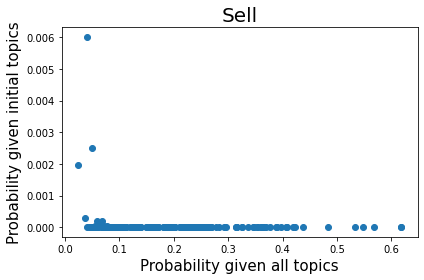

In [222]:
expectedActualPlot("Sell",80,50,doubletsChanged,topicsWordsUp,documentsTopicsUp)

/software/anaconda3/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:62: RuntimeWarning: floating point number truncated to an integer
  vals = special.bdtr(k, n, p)


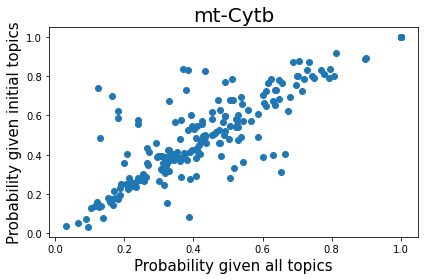

In [221]:
expectedActualPlot("mt-Cytb",80,50,doubletsChanged,topicsWordsUp,documentsTopicsUp)

In [738]:
int_genes = ranking_genes(50,80,scLDAUp7030,topicsWords3070.columns)

#int_genes[int_genes[3]==67].sort_values([1],ascending=False)



,0,1,2,3
656,Rps2,3,0.0222222,[67]
670,Rps5,3,0.0166667,[67]
623,Rpl32,3,0.0193548,[67]
615,Rpl23,3,0.0192308,[67]
796,Tmsb4x,3,0.0150754,[67]
...,...,...,...,...
526,Polb,1,0.0555556,[67]
530,Polr2j,1,0.0555556,[67]
593,Rnaset2b,1,0.0555556,[67]
596,Rnf4,1,0.0555556,[67]


In [786]:
a, b = getROCarrays(50,80,int_genes,up_regulate,list(range(1,2000,5)))

In [788]:
int_genes[0].unique().shape

(7112,)

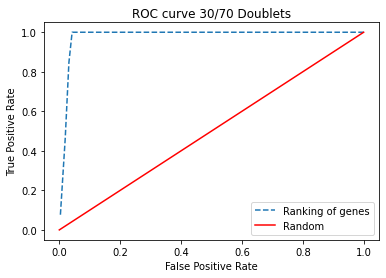

In [790]:
plt.plot(np.array(b)/(int_genes[0].unique().shape[0]-len(up_regulate_subset)),
         np.array(a)/13,'--',label="Ranking of genes")
plt.plot([0,1],[0,1],'r',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve 30/70 Doublets")
plt.legend()
plt.savefig("synthetic_30_70_updated.png",dpi=300)